### Create an Output Folder
The new folder will be created in the Current Directory.  
The saved outputs of this notebook are located in this folder.

In [1]:
import os
import time
start_time_all = time.time()  ## to measure the timelapse 

# Get current working directory
current_dir = os.getcwd()

print("Current directory:", current_dir)

# Name the new folder
Output_folder_main='KNN_Weathers_v1'

Current directory: C:\Users\mohabu\iHelm\CTs4_TSA


In [2]:
# KNN_norm=1; # Normalized data for KNN   #### (Normalizing or not, it is not that big difference)
KNN_norm=0; # Not Normalized data for KNN

In [3]:
nth_mid_sth_fg='Cruising_Speeds' ##(North and South Route Segmentss)
# nth_mid_sth_fg='All_Speeds'  ##(All Route Segments) 

gr_ock_fg=1  ## Select Groto to Ockero voyages only
# gr_ock_fg=0  ## Select Ockero to Groto voyages only
# gr_ock_fg=2  ## ALl data together

top_test_fg=1 ## Reserve some voyages with top eff-scores for test data
###top_test_fg=0

# Eff_limit_combs=[1]
Eff_limit_combs=['Top10'] 
# Eff_limit_combs=['Top25'] 
# Eff_limit_combs=['Top50'] 
# Eff_limit_combs=['Top75'] 

In [4]:
Reg_Mod_inps=5

###############################
disp=8  ## Display the results by rounding to cetain decimal digits
# disp=4

###################
#### ypred_allseq=0 ## To evaluate the predicted SOG for the horizon timesteps in the sequence                                  
ypred_allseq=1 ## To evaluate the predicted SOG for the all sequence (timesteps=all Seq. length, wd_sz)     
###################

inputs_str='Default' ##Default; 

# var_inputs_combs=[5] 
var_inputs_combs=[12]; inputs_str='Weathers'

###################
lag_test_combs=[1]
# lag_test_combs=[5]

#####################
wd_sz=27

rt_len=27

Hrz_test=lag_test_combs[0]
#####################

out_sw='SOG'  ## Output is SpeedOverGround
# out_sw='Eff_Score'## output is eff_score
###################

### gr_ok_dt_fg=0  ##use ockero to groto data
# gr_ok_dt_fg=1  ##use groto to ockero data
gr_ok_dt_fg='alldata'  ##use groto to ockero data

In [5]:
### LSTM options ###
train_pt=0.70  ## partition data between training and test
test_pt=0.81   ## partition data between valid and test
###################

# SampNo_lstm=100
SampNo_lstm=32
###################

Stand_norm_combs=[1]

lyr_combs=[3]

neo_combs=[50]

epcs_combs=[50]

learn_rt=[0.01]

act_fn=['relu']

optimizer = ['Adam']


In [6]:
# tm_stps=1  ### 1 step forecasting
tm_stps=2  ### multiple-steps forecasting, It is the sequence length>20 steps
################
stml_fg=0 
# stml_fg=1  ## stml with drop layer4
################

# tempo_res='5min'  
tempo_res='1min'  
# tempo_res='30S'  

#####################

seq_idx=5

save_sw=0  ### No saving models

In [7]:
Output_folder = Output_folder_main+'/SampLSTM_'+str(SampNo_lstm)+'/NMS_'+str(nth_mid_sth_fg)+'/EffTp_'+str(Eff_limit_combs[0])+'/GrOck_'+str(gr_ock_fg)+'_loc_'+'_inps_'+str(var_inputs_combs[0])+'_lag_'+str(lag_test_combs[0])

In [8]:
## Create the output folder
folder_path = r''+Output_folder
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [9]:
import os
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta

import netCDF4 as nc
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, LeakyReLU
from keras import backend as k
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


import tensorflow as tf
tf.random.set_seed(42)
from numpy.random import seed
seed(0)

import warnings
warnings.filterwarnings("ignore")

In [10]:
##import data
#############
df = pd.read_csv('Data/Data.csv') ## if the data in CSV file

df.shape

(39193, 71)

In [11]:
dforig=df
df.head()

,RT_id,time_xPorts,eff_score,latitude,longitude,accelPedalPos,headingMagnetic,courseOverGroundTrue,speedOverGround,pitch,...,windDirection_cds,wind_head_diff,date,local_eff_score,Gr_Ock_fg,Direct_RT,accel_data,F1_score,Eff_new,eff_score_old
0,248,1,0.410889,57.711047,11.659483,29.336750,239.203157,63.764782,1.738404,0.014409,...,228.614059,239.203157,2020-01-16 13:10:00,0.680602,0,0,0.000000,0.589111,0.410889,0.702661
1,248,2,0.410889,57.711401,11.660977,61.683917,130.172187,82.782518,2.088625,0.031427,...,228.516052,130.172187,2020-01-16 13:11:00,0.129180,0,0,0.350221,0.589111,0.410889,0.702661
2,248,3,0.410889,57.712142,11.664302,64.696250,66.558752,63.644947,4.688200,0.020384,...,228.418045,66.558752,2020-01-16 13:12:00,0.403199,0,0,2.599575,0.589111,0.410889,0.702661
3,248,4,0.410889,57.713221,11.668567,64.650250,70.919434,66.850144,4.658400,0.020279,...,228.320023,70.919434,2020-01-16 13:13:00,0.400802,0,0,-0.029800,0.589111,0.410889,0.702661
4,248,5,0.410889,57.714124,11.672979,64.538967,74.650272,71.377441,4.734000,0.019694,...,228.222015,74.650272,2020-01-16 13:14:00,0.421207,0,0,0.075600,0.589111,0.410889,0.702661


In [12]:
df.RT_id.max()
len(df.RT_id.unique())

1754

In [13]:
df.columns

Index(['RT_id', 'time_xPorts', 'eff_score', 'latitude', 'longitude',
       'accelPedalPos', 'headingMagnetic', 'courseOverGroundTrue',
       'speedOverGround', 'pitch', 'roll', 'windSpeedOverGround',
       'windDirectionTrue', 'fuelPerStep', 'deltaDistance',
       'courseHeadingDiff', 'distanceFromDock', 'distanceToNextDock',
       'distanceToPreviousDock', 'accumDistLeg', 'accumFuelLeg',
       'accumTimeLeg', 'directionTrue', 'EngineFuelRate', 'speedApparent',
       'wind_course_diff', 'distance', 'fuel', 'time', 'time_norm',
       'distance_norm', 'fuel_norm', 'duration', 'fuel_total', 'time_total',
       'distance_total', 'engineFuelRate', 'windSpeed', 'windDirection',
       'waveheight', 'wavedirect', 'waveperiod', 'wavedrag_coeff',
       'speedOverGround_poly2', 'speedOverGround_poly3', 'fuel_Sp_formula',
       'speedOverGround_poly3_2', 'waveheight_poly3', 'windspeed_poly1_5',
       'meanwaveperiod', 'heading_wave', 'heading_wind', 'Cos_HWaveP',
       'Cos_HWindP', 

In [14]:
# st=stop

In [15]:
if gr_ock_fg==1:
    df=df[df.Gr_Ock_fg==1]   
if gr_ock_fg==0:
    df=df[df.Gr_Ock_fg==0]
if gr_ock_fg==2:
    df=df
    
print(df.shape)
print(df.Gr_Ock_fg.unique())

(20436, 71)
[1]


In [16]:
df[(df.Direct_RT==1)].shape

(396, 71)

In [17]:
if nth_mid_sth_fg=='Cruising_Speeds':
    df_NS=df[(df.Direct_RT==0) & 
              (((df.latitude>57.71) & (df.longitude<11.679)) | ((df.latitude<57.705) & (df.longitude>11.686)))]
    NS_idx=df_NS.index
    print(df_NS.shape)
    df=df_NS
    
    
if nth_mid_sth_fg=='All_Speeds':
    df=df[(df.Direct_RT==0)]
    
print(nth_mid_sth_fg)
df.shape

(10665, 71)
Cruising_Speeds


(10665, 71)

In [18]:
df1=df
df1.shape

(10665, 71)

In [19]:
top_test_rts=[5, 66, 131, 280, 326, 444, 458, 464, 513, 602]  ##eff_score > df.eff_score.quantile(0.75)
df1_eff_sort=pd.DataFrame([])

df1_eff_sort1=df1[~df1['RT_id'].isin(top_test_rts)].sort_values(by=['eff_score'], ascending=[False])

rt_id=df1_eff_sort1.RT_id.unique().tolist()
for id in rt_id:
    if id in top_test_rts:
        df1_eff_sort=df1_eff_sort.append(df1[(df1.RT_id==id)])
    else:
##         rt_id=df1_eff_sort1.RT_id[0]
        df1_eff_sort=df1_eff_sort.append(df1_eff_sort1[(df1_eff_sort1.RT_id==id)].sort_values(by=['time_xPorts'], ascending=[True]))

df1_eff_sort=df1_eff_sort.append(df1[df1['RT_id'].isin(top_test_rts)])

print(df1_eff_sort.shape)

(10665, 71)


#### User-defined functions

In [20]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# num=11

def df_to_seq(df, wd_sz, inputs, outputs):
    from keras.preprocessing.sequence import pad_sequences
    maxlen = wd_sz
    i_rt = df['RT_id'].unique()
    df2 = df.to_numpy()

    x = []
    y = []

    inps_index = [df.columns.get_loc(col) for col in inputs]
    outs_index = [df.columns.get_loc(col) for col in outputs]

    for k in i_rt:
        df_rt = df2[df2[:, 0] == k, :]
        rows = df_rt[:, inps_index]
        labels = df_rt[:, outs_index]

        x.append(rows)
        y.append(labels)

    X = pad_sequences(x, maxlen=maxlen, padding='post', dtype='float32')
    Y = pad_sequences(y, maxlen=maxlen, padding='post', dtype='float32')

    return X, Y


def prep_data(X, Y, lag_test, wd_sz, inputs, outputs):
    if inputs==['speedOverGround']:
        X = X[:, 0:lag_test]
        Y = Y[:, lag_test:wd_sz]
        timesteps=lag_test
        numFeatures = 1
        exag_list=[]
    else:                                    
        out_idx=inputs.index(outputs[0])
        exag_list=list(range(X.shape[-1]))
#         exag_list.pop(out_idx)
        X = X[:, :,exag_list]
        Y = Y[:, lag_test:wd_sz]
        timesteps=wd_sz
        numFeatures = len(exag_list)
    return X, Y, numFeatures, timesteps, exag_list


def create_model(Numfeats, timesteps, neurons, layers, act_fn, optimizer, learn_rt, Y_train):
    model = Sequential()
    if act_fn=='relu':
        model.add(LSTM(SampNo_lstm, input_shape=(timesteps, Numfeats),activation='relu', kernel_initializer='normal'))

    if act_fn=='LeakyReLU':
        model.add(LSTM(SampNo_lstm, input_shape=(timesteps, Numfeats),activation='LeakyReLU', kernel_initializer='normal'))
    
    for i in range(lyr_no):
        model.add(Dense(units=neo,  kernel_initializer='normal'))
        
    model.add(Dense(Y_train.shape[1], kernel_initializer='normal'))
    
    if optimizer=='Adam':
        model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learn_rt), metrics=[r2_keras])
    if optimizer=='SGD':
        model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=learn_rt), metrics=[r2_keras])
    if optimizer=='RMSprop':
        model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=learn_rt), metrics=[r2_keras])
    return model

def metrics_eval(Y_act, Y_pred):
    mse_1 = mean_squared_error(Y_act, Y_pred, squared=True)
    rmse_1 = mean_squared_error(Y_act, Y_pred, squared=False)
    R2_1=r2_score(Y_act, Y_pred)
    mae=mean_absolute_error(Y_act, Y_pred,)
    rmse_n1=rmse_1/Y_act.max()
    rmse_n1

    print(' MSE: {:.6f}'.format(mse_1))
    print(' RMSE: {:.6f}'.format(rmse_1))
    print('Normalized RMSE: {:.6f}'.format(rmse_n1))
    print('R2: {:.6f}'.format(R2_1))
    print('MAE: {:.6f}'.format(mae))

    return mse_1, rmse_1, R2_1, mae, rmse_n1

# Define r2_keras as an accuracy metrics
def r2_keras(y_true, y_pred):

    ss_res = k.sum(k.square(y_true - y_pred))
    ss_tot = k.sum(k.square(y_true - k.mean(y_true)))
    return 1-ss_res/(ss_tot + k.epsilon())

# Define rmse as a loss function
def rmse(y_true, y_pred):

    return k.sqrt(k.mean(k.square(y_true - y_pred)))# Create the model

def DTW(x, y):
    from sklearn.metrics.pairwise import euclidean_distances
    # Calculate the Euclidean distance
    dist = euclidean_distances(x, y)
    # Initialize the DTW matrix
    DTW = np.zeros((len(x), len(y)))
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0,0] = 0
    # Calculate DTW matrix
    for i in range(1, len(x)):
        for j in range(1, len(y)):
            cost = dist[i, j]
            DTW[i, j] = cost + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])
    # Return the DTW matrix
    return DTW[-1][-1]

In [21]:
# st=stop

#### Visualization of the Eff-Scores for the vessel's trips in terms of fuel and time domains

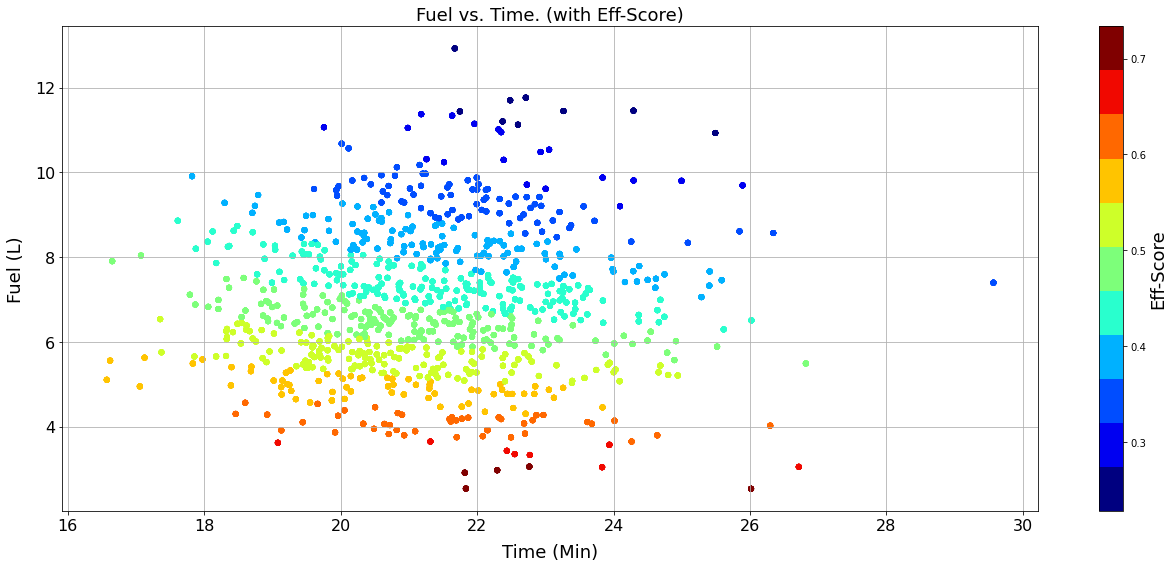

In [22]:
import matplotlib.ticker as ticker

num=11

fig = plt.figure(figsize=(18,8))

im=plt.scatter(x=df1.time_total, y=df1.fuel_total, c=df1.Eff_new,  cmap=discrete_cmap(num, 'jet'), s=25, label='Eff-Score')
cb=plt.colorbar(im)
cb.set_label("Eff-Score", labelpad=3, fontsize=18)

plt.ylabel('Fuel (L)', fontsize=18, labelpad=10)
plt.xlabel('Time (Min)', fontsize=18, labelpad=10)
plt.yticks(fontsize=16);
plt.xticks(fontsize=16, rotation = 0);
plt.title('Fuel vs. Time. (with Eff-Score)',fontsize=18)
# plt.legend(loc='upper left', fontsize=14)
plt.grid()


plt.tight_layout()
# plt.savefig(Output_folder+'/Plot_New_Effscore_fltm_'+'_gr_ock_'+str(gr_ock_fg)+'_NmidS_'+str(nth_mid_sth_fg)+'.png', dpi=300)

plt.show();

In [23]:
# st=stop

### Combinations of variety of options

In [24]:
Res_eff_sog_stats=pd.DataFrame([])
dfst_iter=[]; dfst_var_inputs=[]; dfst_inps=[]; dfst_Reginps=[]; dfst_Stand_norm=[]; 
dfst_Stand_norm=[]; 
dfst_inps_list=[]; dfst_outs_list=[];

dfst_Lyrs=[]; dfst_Neo=[]; dfst_epcs=[]; dfst_learn_rt=[]
dfst_gr_ok_dt_fg=[]; dfst_Eff_limit_fg=[]; dfst_lag_test=[]; dfst_hrz=[]

dfst_sog_meas_avg=[]; dfst_sog_pred_avg=[]; 
dfst_eff_meas_avg=[];dfst_eff_pred_avg=[];dfst_eff_pred_meas_avg=[];

dfst_MSE_sog=[];dfst_RMSE_sog=[];dfst_R2_sog=[];dfst_MAE_sog=[];
dfst_MSE_eff_pred=[];dfst_RMSE_eff_pred=[];dfst_R2_eff_pred=[];dfst_MAE_eff_pred=[];
dfst_MSE_eff_meas=[];dfst_RMSE_eff_meas=[];dfst_R2_eff_meas=[];dfst_MAE_eff_meas=[];
                                
dfst_improv_meas=[]; dfst_improv_pred_meas=[];

kk=0

In [25]:
import time
start_time = time.time()  ## to measure the timelapse 

for Eff_limit_fg in Eff_limit_combs:
    for var_inputs in var_inputs_combs:
        for lag_test in lag_test_combs:
            for lyr_no in lyr_combs:
                for neo in neo_combs:
                    for epcs in epcs_combs:
                        
                        import tensorflow as tf
                        tf.random.set_seed(42)
                        from numpy.random import seed
                        seed(0)

                        ##########################################################################################################
                        outputs=['speedOverGround']

                        if var_inputs==0:
                            inputs=['speedOverGround']

                        if var_inputs==1:
                            inputs=['speedOverGround', 'latitude', 'longitude','headingMagnetic']

                        if var_inputs==2:
                            inputs=['speedOverGround', 'windSpeed_onboard', 'windDirection_onboard','wind_head_diff']

                        if var_inputs==3:
                            inputs=['speedOverGround', 'latitude', 'longitude','headingMagnetic', 'windSpeed_onboard', 'windDirection_onboard',
                               'wind_head_diff']

                        if var_inputs==4:
                            inputs=['speedOverGround', 'latitude', 'longitude', 'headingMagnetic', 'windSpeed_onboard', 'windDirection_onboard', 
                               'wind_course_diff', 'windSpeed_cds','windDirection_cds','windSpeed_sg', 'windDirection_sg',
                               'waveheight','wavedirect', 'currentSpeed', 'currentDirection'] 

                        if var_inputs==5: 
                            inputs=['speedOverGround', 'courseOverGroundTrue','distanceFromDock', 'accumDistLeg', 'accumTimeLeg',
                               'distanceToNextDock', 'speedApparent', 'pitch', 'wind_course_diff', 'roll', 'latitude', 'longitude', 
                               'windSpeed_onboard','windDirection_onboard', 'currentSpeed','currentDirection', 'windSpeed_sg','windDirection_sg',
                               'windSpeed_cds','windDirection_cds', 'waveheight','wavedirect']
                            
                        if var_inputs==6:
                            inputs=['speedOverGround', 'courseOverGroundTrue',
                                'distanceFromDock', 'accumDistLeg','distanceToNextDock',
                                'latitude', 'longitude', 
                                'windSpeed_onboard', 'windDirection_onboard', 'currentSpeed','currentDirection', 'windSpeed_sg','windDirection_sg',
                                 'windSpeed_cds','windDirection_cds', 'waveheight','wavedirect']
            
                        if var_inputs==7:
                            inputs=['speedOverGround', 'courseOverGroundTrue',
                                'latitude', 'longitude', 'waveheight', 'wavedirect']

                        if var_inputs==8:
                            inputs=['speedOverGround', 'courseOverGroundTrue',
                                    'distanceFromDock', 'accumDistLeg','distanceToNextDock',
                                    'latitude', 'longitude', 'waveheight', 'wavedirect']
                            
                        if var_inputs==9:
                            inputs=['speedOverGround', 'courseOverGroundTrue',
                                    'latitude', 'longitude', 'wavedirect']

                        if var_inputs==10:
                            inputs=['speedOverGround', 'courseOverGroundTrue',
                                    'currentSpeed','currentDirection', 'windSpeed_sg','windDirection_sg',
                                    'windSpeed_cds','windDirection_cds', 'waveheight','wavedirect']
                            
                        if var_inputs==11:
                            inputs=['speedOverGround', 'courseOverGroundTrue',
                                     'wavedirect']            
                            
                        if var_inputs==12:
                            inputs=['speedOverGround', 'courseOverGroundTrue',
                                'windSpeed_onboard', 'windDirection_onboard', 'currentSpeed','currentDirection', 'windSpeed_sg','windDirection_sg',
                                 'windSpeed_cds','windDirection_cds', 'waveheight','wavedirect']

                        var_inputs_index = var_inputs

#                        file_nm_ext='_Efflm'+str(Eff_limit_fg)+'_inp_'+str(var_inputs)+'_lag_'+str(lag_test)+'_lyr_'+str(lyr_no)+'_Neo_'+str(neo)+'_epc_'+str(epcs)
                        file_nm_ext='_Efflm'+str(Eff_limit_fg)
############################################################################################################################  
                        if Eff_limit_fg==1:
                            X, Y=df_to_seq(df1, wd_sz, inputs, outputs)
                            X_orig, Y_orig=X, Y
                            rt_id=df1.RT_id.unique()

                            ##### Preparing data for multiple-steps  forcasting with multiple-step lags
                            X, Y, numFeatures, timesteps, exag_list=prep_data(X, Y, lag_test, wd_sz, inputs, outputs)

                        if Eff_limit_fg!=1:

                            if Eff_limit_fg=='Top10':
                                Qlim=df['eff_score'].quantile(0.90)
                            if Eff_limit_fg=='Top25':
                                Qlim=df['eff_score'].quantile(0.75)
                            if Eff_limit_fg=='Top50':
                                Qlim=df['eff_score'].quantile(0.50)
                            if Eff_limit_fg=='Top75':
                                Qlim=df['eff_score'].quantile(0.25)

                            X, Y=df_to_seq(df1_eff_sort, wd_sz, inputs, outputs)
                            X_orig, Y_orig=X, Y
                            rt_id=df1_eff_sort.RT_id.unique()

                            if top_test_fg==0:
                                df1_eff_top=df1_eff_sort[df1_eff_sort.eff_score>=Qlim]
                            if top_test_fg==1:
                                df1_eff_top=df1_eff_sort[(df1_eff_sort.eff_score>=Qlim) & (~df1_eff_sort.RT_id.isin(top_test_rts))]

                            top2bot=len(df1_eff_top)/len(df1)
                            train_pt=top2bot
                            X, Y, numFeatures, timesteps, exag_list=prep_data(X, Y, lag_test, wd_sz, inputs, outputs)

                        print(X.shape)
                        print(Y.shape)

                        scaler = StandardScaler()
                        X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1]))
                        Y_scaled = scaler.fit_transform(Y.reshape(-1, Y.shape[-1]))
                        X=X_scaled.reshape(X.shape)
                        Y=Y_scaled.reshape(Y.shape)

                        X_train,X_valid,X_test = np.split(X,[int(train_pt*len(X)),int(test_pt*len(X))])
                        Y_train,Y_valid,Y_test = np.split(Y,[int(train_pt*len(Y)),int(test_pt*len(Y))])
                        rt_id_train,rt_id_valid,rt_id_test = np.split(rt_id,[int(train_pt*len(rt_id)),int(test_pt*len(rt_id))])

                        #############################
                        scaler = StandardScaler()
                        X_orig_scaled = scaler.fit_transform(X_orig.reshape(-1, X_orig.shape[-1]))
                        X_orig_scaled = X_orig_scaled.reshape(X_orig.shape)
                        Y_orig_scaled = scaler.fit_transform(Y_orig.reshape(-1, Y_orig.shape[-1]))
                        Y_orig_scaled = Y_orig_scaled.reshape(Y_orig.shape)

                        X_orig_sc_train,X_orig_sc_valid,X_orig_sc_test = np.split(X_orig_scaled,[int(train_pt*len(X_orig_scaled)),int(test_pt*len(X_orig_scaled))])
                        X_orig_train,X_orig_valid,X_orig_test = np.split(X_orig,[int(train_pt*len(X_orig)),int(test_pt*len(X_orig))])

                        Y_orig_sc_train,Y_orig_sc_valid,Y_orig_sc_test = np.split(Y_orig_scaled,[int(train_pt*len(Y_orig_scaled)),int(test_pt*len(Y_orig_scaled))])
                        Y_orig_train,Y_orig_valid,Y_orig_test = np.split(Y_orig,[int(train_pt*len(Y_orig)),int(test_pt*len(Y_orig))])

#                         st=stop

# ########################################################################################################################
###################################################################################################################################

                        # Use KNN to calculate similarity for test dataset using the nearest neighbors

                        from sklearn.neighbors import NearestNeighbors

                        # Extract weather data from the array

                        if KNN_norm == 0:
                            W_test = X_orig_test
                            W_train = X_orig_train

                        if KNN_norm == 1:
                            W_test = X_orig_sc_test
                            W_train = X_orig_sc_train

                        weather_data_train = W_train[:, :26, 2:]
                        weather_data_test = W_test[:, :26, 2:]

                        # Number of neighbors to consider (you can adjust this as needed)
                        n_neighbors = 1  # Set the desired number of neighbors

                        # Reshape weather data to 2D arrays
                        weather_data_train_2d = weather_data_train.reshape(weather_data_train.shape[0], -1)
                        weather_data_test_2d = weather_data_test.reshape(weather_data_test.shape[0], -1)

                        # Create a KNN model
                        knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')  # You can choose a different metric if needed

                        # Fit the KNN model on observed weather data
                        knn.fit(weather_data_train_2d)

                        Simi_dict = {}

                        for i in range(W_test.shape[0]):
                            weathers_test = W_test[i, :26, 2:]
                            weathers_test_2d = weathers_test.reshape(1, -1)

                            # Find the nearest neighbors and their distances
                            distances, indices = knn.kneighbors(weathers_test_2d)

                            # The nearest neighbor's index is stored in indices[0, 0]
                            min_index = indices[0, 0]
                            Simi_dict[i] = min_index

                        # Create a list sim_rts_test with the indices of nearest neighbors
                        sim_rts_test = list(Simi_dict.values())
                        print(len(sim_rts_test))
                        
#                         st=stop
##########################################################################################################################
####Arrangement of the Predicted Profiles of SOG from the Similarity Algo. (DTW) above #####
                        
                        Ypred1=[]
                        y_pred1=Y_orig_sc_train[sim_rts_test,Hrz_test:, 0]

                        Ypred1=np.concatenate((Y_orig_sc_test[:,:lag_test,0], y_pred1), axis=1)
                        Ytest1=np.concatenate((Y_orig_sc_test[:,:lag_test,0], Y_test[:, :, 0]), axis=1)

                        YPred1 = scaler.inverse_transform(Ypred1.reshape(-1, Ypred1.shape[-1]))
                        YPred1=YPred1.reshape(Ypred1.shape)
                        YTest1 = Y_orig_test
                        
                        # Set Ypred max values to Ytest max if greater
                        if YPred1.max() > YTest1.max():
                            YPred1[YPred1 > YTest1.max()] = YTest1.max()

                        # Set Ypred min values to Ytest min if smaller
                        if YPred1.min() < YTest1.min():
                            YPred1[YPred1 < YTest1.min()] = YTest1.min()

                        Ypred_sog_avg1=YPred1.mean(axis=1)  ## average speed (predicted)
                        Ypred_sog_avg1

                        Ytest_sog_avg1=YTest1.reshape(Ytest1.shape).mean(axis=1)  ## average speed (measured)
                        Ytest_sog_avg1
                        
                        Y_pred=YPred1.reshape(-1,1)
                        Y_act=YTest1.reshape(-1,1)

                        Y_pred[np.isnan(Y_pred)] = 0

                        ### Metrics for the predictions for all sequences
                        print('\n Metrics for SOG predictions, the accuracy here is not a priority!')
                        mse_sog, rmse_sog, R2_sog, mae_sog, rmse_n_sog=metrics_eval(Y_act, Y_pred)

                        hrz=wd_sz-lag_test
                        Res_sog_avg_stats1=pd.DataFrame({'Gr_Ock_idx':gr_ok_dt_fg,
                            'Top_Samps_idx':Eff_limit_fg,'Time_Steps_Lag':lag_test,'Time_Steps_Ahead':hrz,
                                                        'Inputs_index': var_inputs,'No_inputs':len(inputs),'inputs':[inputs], 'outputs':[outputs], 
                                                    'No#_layers':lyr_no,'No# neurons':neo, 'epochs':epcs,'Learn Rate':learn_rt,
                                                    'MSE_sog':round(mse_sog,4), 'RMSE_sog':round(rmse_sog,4), 'R2_sog':round(R2_sog,4), 'MAE_sog':round(mae_sog,4)})

                        Res_sog_avg_stats1.index=['Avg_Stats']
                        SOG_avg_stats1=Res_sog_avg_stats1


                        scaler = StandardScaler()
                        y_pred_scaled = scaler.fit_transform(Ypred1.reshape(-1, Y_orig.shape[-1]))
                        y_pred_scaled = y_pred_scaled.reshape(Ypred1.shape)

                        print(y_pred_scaled.mean())  ###data scaled mean should be 0
                        print(y_pred_scaled.std())  ###data scaled std should be 1

                        Ypred_sog_sqs1=np.concatenate((X_test[:,:lag_test,0], y_pred1), axis=1) 

                        print(Ypred_sog_sqs1.mean())  ### Mean is not 0, because SOG_pred congated with SOG_meas
                        print(Ypred_sog_sqs1.std())  ###Std is not 1, because SOG_pred congated with SOG_meas

#                         st=stop
########################################################################################################################
                        #### Eff-Score Prediction from Predicted SOG ###

                        out_sw='Eff_Score'

                        if Reg_Mod_inps==0:
                            inputs=['speedOverGround']
                        if Reg_Mod_inps==1:
                            inputs=['speedOverGround', 'windSpeedOverGround', 'windDirectionTrue', 'wind_head_diff']
                        if Reg_Mod_inps==2:
                            inputs=['speedOverGround', 'headingMagnetic', 'latitude', 'longitude']
                        if Reg_Mod_inps==3:
                            inputs=['speedOverGround', 'headingMagnetic', 'latitude', 'longitude',
                                   'windSpeedOverGround', 'windDirectionTrue', 'wind_head_diff']

                        if Reg_Mod_inps==5: 
                            inputs=['speedOverGround', 'courseOverGroundTrue','distanceFromDock', 'accumDistLeg', 'accumTimeLeg',
                               'distanceToNextDock', 'speedApparent', 'pitch', 'wind_course_diff', 'roll', 'latitude', 'longitude', 
                               'windSpeed_onboard','windDirection_onboard', 'currentSpeed','currentDirection', 'windSpeed_sg','windDirection_sg',
                               'windSpeed_cds','windDirection_cds', 'waveheight', 'wavedirect']                                       


                        if out_sw=='SOG':
                            outputs=['speedOverGround']

                        if out_sw=='Eff_Score':
                            outputs=['eff_score']

                        if Eff_limit_fg==1:
                            X2, Y2=df_to_seq(df1, wd_sz, inputs, outputs)
                            X_orig2, Y_orig2=X2, Y2

                        if Eff_limit_fg!=1:

                            if Eff_limit_fg=='Top10':
                                Qlim=df['eff_score'].quantile(0.90)
                            if Eff_limit_fg=='Top25':
                                Qlim=df['eff_score'].quantile(0.75)
                            if Eff_limit_fg=='Top50':
                                Qlim=df['eff_score'].quantile(0.50)
                            if Eff_limit_fg=='Top75':
                                Qlim=df['eff_score'].quantile(0.25)

                            X2, Y2=df_to_seq(df1_eff_sort, wd_sz, inputs, outputs)

                        if var_inputs==0:
                            numFeatures = 1
                        if var_inputs!=0:
                            numFeatures = len(inputs)

                        Y2=Y2[:,0,0]  ### one value for Eff_score, the first because the last value padded
                        Y2=Y2.reshape(Y.shape[0],1)

                        scaler = StandardScaler()
                        X_scaled2 = scaler.fit_transform(X2.reshape(-1, X2.shape[-1]))
                        X2=X_scaled2.reshape(X2.shape)

                        X_train2,X_valid2,X_test2 = np.split(X2,[int(train_pt*len(X2)),int(test_pt*len(X2))])
                        Y_train2,Y_valid2,Y_test2 = np.split(Y2,[int(train_pt*len(Y2)),int(test_pt*len(Y2))])

#                         st=stop                                
    ##################################################################################################################

                        X_at_sog_meas=X_test2

                        X_test_2d = X_at_sog_meas.reshape(X_at_sog_meas.shape[0], -1)

                        # saving reshaped array to file.
                        np.savetxt("x_test_2dlastseqvalue12.txt", X_test_2d)

#                         st=stop

    #####################################################################################################################
                        ### Predcition Eff-Score by using LSTM, when SOG is Predicted from LSTM
                        ###### Replacing the SOG in Test dataset by the predicted SOG from the LSTM
            
                        if save_sw==0:
                            batch_size=round(0.05*X_train.shape[0])  ###fixed batch size base on size of Training dataset

                            Eff_model = create_model(numFeatures, wd_sz, neo, lyr_no, act_fn[0], optimizer[0], learn_rt[0], Y_train2)
                            history = Eff_model.fit(X_train2, Y_train2, batch_size, validation_data=(X_valid2, Y_valid2), epochs=epcs,  verbose=1)

                            #### Plot Train and Valid
#                             if kk==0:
#                                 fig = plt.figure(figsize=(14,5))
#                                 plt.subplot(1,2, 1)
#                                 plt.plot(history.history['loss'], label='Training')
#                                 plt.plot(history.history['val_loss'], label='Validation')
#                                 plt.title('Training and Validation')
#                                 plt.xlabel('Epochs')
#                                 plt.ylabel('Loss')
#                                 plt.ylim(0,1)
#                                 plt.legend()
#                                 plt.grid()


#                                 plt.subplot(1,2, 2)
#                                 plt.plot(history.history['r2_keras'], label='Training')
#                                 plt.plot(history.history['val_r2_keras'], label='Validation')
#                                 plt.title('Training and Validation')
#                                 plt.xlabel('Epochs')
#                                 plt.ylabel('R2')
#                                 plt.ylim(0,1)
#                                 plt.legend()
#                                 plt.grid()

#                                 plt.tight_layout()
#                                 plt.savefig(Output_folder+'/TrainPlt'+file_nm_ext+'.png', dpi=300)
#                                 plt.show()

#                             st=stop

                        ### prediction  ###

                        SOG_index=inputs.index("speedOverGround")
                        SOG_index
                        X_test2[:,:,SOG_index]=Ypred_sog_sqs1

                        X_test2.shape

                        ###Predict EFF
                        #########################################                                               
                        if save_sw==1:
                            if gr_ock_fg==1:
                                from keras.models import load_model
                                Eff_model= load_model('Data/Saved_Models/Eff_model_gr_ock_fg_1.h5',
                                         custom_objects={'rmse':rmse, 'r2_keras':r2_keras}) 
                        ##########################################
                        y_pred2 = Eff_model.predict(X_test2)

                        Y_act2=Y_test2[:,0]

                        Y_pred2=y_pred2.reshape(-1)
                        Y_pred2[np.isnan(Y_pred2)] = 0

                        ### Evaluation of Eff_Score for all Sequences in Testing dataset

                        Ytest_eff_avg=Y_act2.mean()  ## average speed (measured)
                        Ytest_eff_avg

                        Ypred_eff_avg=Y_pred2.mean()  ## average speed (predicted)
                        Ypred_eff_avg

                        ### Metrics for the predictions for all sequences
                        print('\n Metrics for Eff-score predictions using predicted SOG')
                        mse_eff, rmse_eff, R2_eff, mae_eff, rmse_n_eff=metrics_eval(Y_act2, Y_pred2)

                        Res_eff_sog_pred=pd.DataFrame({'Gr_Ock_idx':gr_ok_dt_fg,
                            'Top_Samps_idx':Eff_limit_fg,'Time_Steps_Lag':lag_test,'Time_Steps_Ahead':hrz,
                                                        'Inputs_index': var_inputs,'No_inputs':len(inputs),'inputs':[inputs], 'outputs':[outputs], 

                                                    'Ytest_eff_avg':round(Ytest_eff_avg,4), 'Pred_eff_avg':round(Ypred_eff_avg,4),

                                                    'MSE_sog':round(mse_sog,4), 'RMSE_sog':round(rmse_sog,4), 'R2_sog':round(R2_sog,4), 'MAE_sog':round(mae_sog,4),

                                                    'MSE_eff':round(mse_eff,4), 'RMSE_eff':round(rmse_eff,4), 'R2_eff':round(R2_eff,4), 'MAE_eff':round(mae_eff,4)})

                        Res_eff_sog_pred.index=['Avg_Stats']
                        Res_eff_sog_pred

                        Res_eff_sog_pred[[ 'Ytest_eff_avg','Pred_eff_avg']]

                        Res_eff_sog_pred[['MSE_sog', 'RMSE_sog', 'R2_sog', 'MAE_sog', 'MSE_eff', 'RMSE_eff', 'R2_eff', 'MAE_eff']]

#                         st=stop
    #####################################################################################################################
                        ### Predcition Eff-Score by using LSTM with measured variables from onboard data
                        #### Here SOG in Test dataset is the measured SOG from Onboard data

                        # x_test=x_test_sog_meas
                        ### retrieving data from file.
                        X_test_arr = np.loadtxt("x_test_2dlastseqvalue12.txt")
                        X_test3=X_test_arr
                        Y_test3=Y_test2

                        X_test_arr=X_test_arr.reshape(X_test2.shape)

                        ####Predict
                        #### saved Model (The same model that used with optimal predicted SOG)
                        y_pred3 = Eff_model.predict(X_test_arr)

                        Y_act3=Y_test3[:,0]
                        Y_pred3=y_pred3.reshape(-1)
                        Y_pred3[np.isnan(Y_pred3)] = 0

                        ### Evaluation of Eff_Score for all Sequences in Testing dataset

                        Ytest_eff_avg=Y_act3.mean()  ## average speed (measured)
                        Ytest_eff_avg

                        Ypred_eff_avg=Y_pred3.mean()  ## average speed (predicted)
                        Ypred_eff_avg

                        #### Metrics for the predictions for all sequences
                        print('\n Metrics for Eff-score predictions using measured values')
                        mse_eff, rmse_eff, R2_eff, mae_eff, rmse_n_eff=metrics_eval(Y_act3, Y_pred3)

                        Res_eff_sog_meas=pd.DataFrame({'Gr_Ock_idx':gr_ok_dt_fg,
                            'Top_Samps_idx':Eff_limit_fg,'Time_Steps_Lag':lag_test,'Time_Steps_Ahead':hrz,
                                                        'Inputs_index': var_inputs,'No_inputs':len(inputs),'inputs':[inputs], 'outputs':[outputs], 

                                                    'Ytest_eff_avg':round(Ytest_eff_avg,4), 'Pred_eff_avg':round(Ypred_eff_avg,4),

                                                    'MSE_sog':round(mse_sog,4), 'RMSE_sog':round(rmse_sog,4), 'R2_sog':round(R2_sog,4), 'MAE_sog':round(mae_sog,4),

                                                    'MSE_eff':round(mse_eff,4), 'RMSE_eff':round(rmse_eff,4), 'R2_eff':round(R2_eff,4), 'MAE_eff':round(mae_eff,4)})

                        Res_eff_sog_meas.index=['Avg_Stats']

    ################################### Evaluation of Test sequences (routes)  #######################################

                        df_eff_sog_seqs=pd.DataFrame([])
                        dfst_sogtest=[]; dfst_sogpred=[]; 
                        dfst_eff_meas=[]; dfst_eff_pred_meas_sog=[];dfst_eff_pred_sog=[]
                        dfst_improv_eff_vs_meas=[]; dfst_improv_eff_vs_pred_meas=[]

                        dfst_sogtest=np.round(Ytest_sog_avg1,4)
                        dfst_sogpred=np.round(Ypred_sog_avg1,4)
                        dfst_eff_meas=np.round(Y_act3,disp)
                        dfst_eff_pred_meas_sog=np.round(Y_pred3,disp)
                        dfst_eff_pred_sog=np.round(Y_pred2,disp)
                        dfst_improv_eff_vs_meas=dfst_eff_pred_sog-dfst_eff_meas
                        dfst_improv_eff_vs_pred_meas=dfst_eff_pred_sog-dfst_eff_pred_meas_sog

                        df_eff_sog_seqs=pd.DataFrame({'Sog_test': dfst_sogtest, 'Sog_pred': dfst_sogpred,
                                                  'Eff_meas': dfst_eff_meas, 'Eff_pred_meas_sog': dfst_eff_pred_meas_sog, 
                                                  'Eff_pred_sog': dfst_eff_pred_sog,
                                                  'Improve_Eff_vs_meas': dfst_improv_eff_vs_meas,
                                                  'Improve_Eff_vs_pred_meas': dfst_improv_eff_vs_pred_meas})
                        df_eff_sog_seqs

                        sym=str(round(df_eff_sog_seqs.Improve_Eff_vs_pred_meas.mean(),4))

#                         df_eff_sog_seqs.to_excel(Output_folder+'/Stats_Eff'+str(Eff_limit_fg)+'_inp_'+str(var_inputs)+'_lag_'+str(lag_test)+'.xlsx')

                        kk=kk+1
                        if kk==1:break


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

(848, 27, 12)
(848, 26, 1)
162

 Metrics for SOG predictions, the accuracy here is not a priority!
 MSE: 0.305117
 RMSE: 0.552374
Normalized RMSE: 0.092770
R2: 0.923467
MAE: 0.283144
8.830318e-09
1.0
-0.02422914
0.9541964
Epoch 1/50
21/21 [==============================] - 2s 40ms/step - loss: 0.3159 - r2_keras: -1044.5580 - val_loss: 0.0032 - val_r2_keras: -37274.0195
Epoch 2/50
21/21 [==============================] - 1s 26ms/step - loss: 0.0064 - r2_keras: -23.8582 - val_loss: 0.0392 - val_r2_keras: -473208.7812
Epoch 3/50
21/21 [==============================] - 1s 29ms/step - loss: 0.0024 - r2_keras: -4.1283 - val_loss: 0.0391 - val_r2_keras: -472753.4375
Epoch 4/50
21/21 [==============================] - 1s 27ms/step - loss: 0.0020 - r2_keras: -2.8005 - val_loss: 0.0284 - val_r2_keras: -344231.4375
Epoch 5/50
21/21 [==============================] - 1s 34ms/step - loss: 0.0016 - r2_keras: -2.1086 - val_loss: 0.0151 - val_r2_keras: -184362.8906
Epoch 6/50
21/21 [=================

In [26]:
# st=stop

In [27]:
print(rt_id_test.shape)

(162,)


In [28]:
if gr_ock_fg==2:
    seq_idx=270
else:
    seq_idx=5
    
seq_idx

5

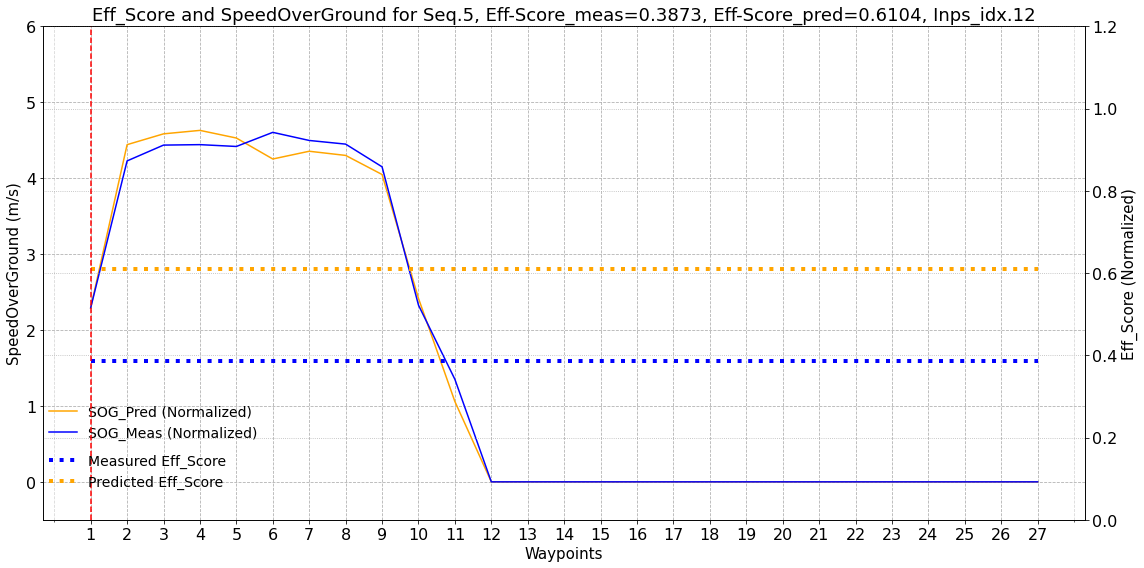

In [29]:
#Plot

if tempo_res=='1min':
    tm='(Min.)'
if tempo_res=='1S':
    tm='(Sec.)' 
Ypred2= y_pred2.reshape(-1)
Ytest2= Y_test2[:,0]

fig, ax1 = plt.subplots(figsize=(16,8))

x_ticks = np.arange(0, len(YPred1[seq_idx]))+1

ax2 = ax1.twinx()
# ax1.plot(range(lag_test, wd_sz),YPred1[seq_idx, lag_test:wd_sz], 'orange',label="SOG_Pred (Normalized)")
ax1.plot(x_ticks, YPred1[seq_idx], 'orange',label="SOG_Pred (Normalized)")
ax1.plot(x_ticks, YTest1[seq_idx], 'b',label="SOG_Meas (Normalized)")
ax2.plot(x_ticks, [Ytest2[seq_idx]]*wd_sz, ':b', label="Measured Eff_Score", linewidth = 4);
ax2.plot(x_ticks, [Ypred2[seq_idx]]*wd_sz, ':', color='orange', label="Predicted Eff_Score",  linewidth = 4)
ax2.axvline(x=lag_test, linestyle='--', color='red')

# Calculate the x-tick positions
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([1] + list(x_ticks[1:]))

plt.xticks(x_ticks);


plt.title('Eff_Score and SpeedOverGround for Seq.'+str(seq_idx)+', Eff-Score_meas='+str(np.round(Y_test2[seq_idx,0],4))
          +', Eff-Score_pred='+str(np.round(Ypred2[seq_idx],4))+', Inps_idx.'+str(var_inputs_index),  fontsize=18)
ax1.set_xlabel('Waypoints',  fontsize=15)
ax1.set_ylabel('SpeedOverGround (m/s)', fontsize=15)
ax2.set_ylabel('Eff_Score (Normalized)', fontsize=15)

ax1.tick_params(axis='y', labelsize=16) 
ax2.tick_params(axis='y', labelsize=16) 
ax1.tick_params(axis='x', labelsize=16) 

ax1.set_ylim(-0.5, 6)
ax2.set_ylim(0, 1.2)

ax1.legend(loc="lower left", bbox_to_anchor=(0.0, 0.15), ncol=1, borderaxespad=0, frameon=False, fontsize=14)
ax2.legend(loc="lower left", bbox_to_anchor=(0.0, 0.05), ncol=1, borderaxespad=0, frameon=False, fontsize=14)

ax1.grid(linestyle='--')
ax2.grid(linestyle=':')


ax2.yaxis.grid(True, which='minor', linestyle=':', color='#cccccc')

ax1.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax1.grid(which='minor', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(Output_folder+'/Plt_Indv_OUPUT_EffSOG_seq'+str(seq_idx)+file_nm_ext+'.png', dpi=300)

plt.show()  

In [30]:
# st=stop

### Check the std div of predicted speed and compare it with the measured speed

In [31]:
YPred1.reshape(-1,1).shape
YTest1.reshape(-1,1).shape
YTest1.reshape(-1,1)[:,0]
dfsog_pred_meas=pd.DataFrame({'SOG_meas':YTest1.reshape(-1,1)[:,0], 'SOG_pred':YPred1.reshape(-1,1)[:,0]})
dfsog_pred_meas.describe()

,SOG_meas,SOG_pred
count,4374.000000,4.374000e+03
mean,1.665287,1.572734e+00
std,1.996925,1.834772e+00
min,0.000000,3.697175e-08
25%,0.000000,3.697175e-08
50%,0.000000,3.697175e-08
75%,4.004475,3.659750e+00
max,5.954200,5.040775e+00


In [32]:
### sog average for each route
df_eff_sog_seqs
df_eff_sog_seqs.describe()

,Sog_test,Sog_pred,Eff_meas,Eff_pred_meas_sog,Eff_pred_sog,Improve_Eff_vs_meas,Improve_Eff_vs_pred_meas
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,1.665291,1.572730,0.351359,0.609295,0.609349,0.257990,0.000053
std,0.095597,0.060793,0.054838,0.004982,0.005028,0.054543,0.000176
min,1.462500,1.426000,0.227908,0.601988,0.602006,0.011488,-0.000371
25%,1.599975,1.526250,0.328145,0.605753,0.605721,0.234019,-0.000056
50%,1.660300,1.579000,0.353162,0.608331,0.608418,0.257001,0.000052
75%,1.726275,1.611425,0.375675,0.611614,0.611633,0.281015,0.000150
max,2.007700,1.722400,0.602137,0.629064,0.629525,0.378147,0.000595


In [33]:
# st=stop

### Prepare data for calcualtion of fuel, distance and time 

In [34]:
def Prep_cal_data(df, wd_sz):
    for k in ['df']:    ### Test data
        df_k=eval(k)    
        i_rt=list(df_k.RT_id.unique())
        dfnew=[]
        dftemp=[]
        result=pd.DataFrame([])

        rt_len=wd_sz

        for i in list(df_k.RT_id.unique()):
            dftemp=df_k[df_k.RT_id==i]
            if len(dftemp)<rt_len:
                rp=rt_len-len(dftemp)
                last_row=df_k[df_k.RT_id==i].iloc[-1]
                last_row=last_row.to_frame().T
                dfadd=pd.DataFrame(last_row.values.repeat(rp, axis=0), columns=last_row.columns)

                zero_cols=last_row.columns.drop(['RT_id','time_xPorts','eff_score'])  

                dfadd[zero_cols]=dfadd[zero_cols]*0
                df_add = pd.concat([dftemp, dfadd]).reset_index()

                df_add = df_add.drop(['index'],axis=1)
            if len(dftemp)==rt_len:
                df_add=dftemp
            result=result.append(df_add)

        dfnew=result
        dfnew['time_xport']=dfnew.index
        dfnew=dfnew.reset_index()
        dfnew = dfnew.drop(['index'],axis=1)
        return dfnew

### Fuel Seq2Seq Reg. Model with 22 variables usign LSTM

In [35]:
out_sw='EngineFuelRate'

Reg_Mod_inps=5
#################################################################################################################
if Reg_Mod_inps==0:
    inputs=['speedOverGround']
if Reg_Mod_inps==1:
    inputs=['speedOverGround', 'windSpeedOverGround', 'windDirectionTrue', 'wind_head_diff']
if Reg_Mod_inps==2:
    inputs=['speedOverGround', 'headingMagnetic', 'latitude', 'longitude']
if Reg_Mod_inps==3:
    inputs=['speedOverGround', 'headingMagnetic', 'latitude', 'longitude',
           'windSpeedOverGround', 'windDirectionTrue', 'wind_head_diff']
if Reg_Mod_inps==4:
    inputs=['speedOverGround', 'latitude', 'longitude','headingMagnetic', 'windSpeed_onboard', 'windDirection_onboard', 
       'wind_course_diff', 'windSpeed_cds','windDirection_cds','windSpeed_sg', 'windDirection_sg',
       'waveheight','wavedirect', 'currentSpeed', 'currentDirection', 'EngineFuelRate'] 
    
if Reg_Mod_inps==5:
    inputs=['speedOverGround', 'courseOverGroundTrue','distanceFromDock', 'accumDistLeg', 'accumTimeLeg',
       'distanceToNextDock', 'speedApparent', 'pitch', 'wind_course_diff', 'roll', 'latitude', 'longitude', 
       'windSpeed_onboard','windDirection_onboard', 'currentSpeed','currentDirection', 'windSpeed_sg','windDirection_sg',
       'windSpeed_cds','windDirection_cds', 'waveheight','wavedirect']
    

if out_sw=='SOG':
    outputs=['speedOverGround']

if out_sw=='Eff_Score':
    outputs=['eff_score']
    
if out_sw=='EngineFuelRate':
    outputs=['EngineFuelRate']
##################################################################################################################
X7, Y7=df_to_seq(df1, wd_sz, inputs, outputs)
X_orig7, Y_orig7=X7, Y7

# if Eff_limit_fg==1:
##### Preparing data for multiple-steps  forcasting with multiple-step lags

if Eff_limit_fg!=1:

    if Eff_limit_fg=='Top10':
        Qlim=df['eff_score'].quantile(0.90)
    if Eff_limit_fg=='Top25':
        Qlim=df['eff_score'].quantile(0.75)
    if Eff_limit_fg=='Top50':
        Qlim=df['eff_score'].quantile(0.50)
    if Eff_limit_fg=='Top75':
        Qlim=df['eff_score'].quantile(0.25)

    X7, Y7=df_to_seq(df1_eff_sort, wd_sz, inputs, outputs)

if var_inputs==0:
    numFeatures = 1
if var_inputs!=0:
    numFeatures = len(inputs)

print(X7.shape)
print(Y7.shape)

scaler = StandardScaler()
X_scaled7 = scaler.fit_transform(X7.reshape(-1, X7.shape[-1]))
X7=X_scaled7.reshape(X7.shape)

X_train7,X_valid7,X_test7 = np.split(X7,[int(train_pt*len(X7)),int(test_pt*len(X7))])
Y_train7,Y_valid7,Y_test7 = np.split(Y7,[int(train_pt*len(Y7)),int(test_pt*len(Y7))])

# st=stop                                
##################################################################################################################

X_at_sog_meas=X_test7

X_test_2d = X_at_sog_meas.reshape(X_at_sog_meas.shape[0], -1)

# saving reshaped array to file.
np.savetxt("x_test_2dlastseqvalue7.txt", X_test_2d)

#                                 st=stop

#####################################################################################################################
##### Load a save LSTM Model, which trained without biased data (not top 50 or 25%)

from keras.models import load_model

if Reg_Mod_inps==3:
    Fuel_model = load_model('Data/Saved_Models/EFF_FL_STML_Seq2Seq_Reg_Mod_Alldata_var_inps_3_lag_0_norm_1_1min_outs_EngineFuelRate_lyrs_2_epc_100_Neo_25_R2_BM_0.5657.hdf5',
                    custom_objects={'rmse':rmse, 'r2_keras':r2_keras}) 
if Reg_Mod_inps==5:
    Fuel_model = load_model('Data/Saved_Models/EFFnew_FL_STML_Seq2Seq_Reg_Mod_Alldata_Efflm1_var_inps_5_lag_0_norm_1_1min_outs_EngineFuelRate_lyrs_2_epc_50_Neo_100_R2_BM_0.5992.hdf5',
                    custom_objects={'rmse':rmse, 'r2_keras':r2_keras}) 
    
Fuel_model.summary()
# st=stop

###################### Fuel prediction from predicted speed #################

SOG_index=inputs.index("speedOverGround")
SOG_index
X_test7[:,:,SOG_index]=Ypred_sog_sqs1

X_test7.shape

#Predict
#### saved Model
y_pred7 = Fuel_model.predict(X_test7)


# ### Evaluation of Eff_Score for all Sequences in Testing dataset

Y_act7=Y_test7.reshape(-1,1)
Y_pred7=y_pred7.reshape(-1,1)

mse_fl, rmse_fl, R2_fl, mae_fl, rmse_n_fl=metrics_eval(Y_act7, Y_pred7)


###################### Fuel prediction from measured speed #################

# x_test=x_test_sog_meas
### retrieving data from file.
X_test_arr7 = np.loadtxt("x_test_2dlastseqvalue7.txt")

X_test7_sog_meas=X_test_arr7.reshape(X_test7.shape)


####Predict
#### saved Model
y_pred7_sog_meas = Fuel_model.predict(X_test7_sog_meas)               

# ### Evaluation of Eff_Score for all Sequences in Testing dataset

Y_act7=Y_test7.reshape(-1,1)
Y_pred7_sog_meas=y_pred7_sog_meas.reshape(-1,1)

mse_fl_sog_meas, rmse_fl_sog_meas, R2_fl_sog_meas, mae_fl_sog_meas, rmse_n_fl_sog_meas=metrics_eval(Y_act7, Y_pred7_sog_meas)

##################################   
r2_sym=round(R2_fl_sog_meas,4) 


(848, 27, 22)
(848, 27, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                7040      
                                                                 
 dense_11 (Dense)            (None, 100)               3300      
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 27)                2727      
                                                                 
Total params: 23,167
Trainable params: 23,167
Non-trainable params: 0
_________________________________________________________________
 MSE: 194.328018
 RMSE: 13.940159
Normalized RMSE: 0.209714
R2: 0.344035
MAE: 10.627447
 MSE: 222.094589
 RMSE: 14.902839
Normalized RMSE: 0.224197
R2: 0.2

In [36]:
# fig = plt.subplots(figsize=(10,5))

# plt.plot(Y_test7[seq_idx,:,0], label='Meas_FuelRate')
# plt.plot(y_pred7[seq_idx],'orange', label='Pred_FuelRate_sog_pred')
# plt.plot(y_pred7_sog_meas[seq_idx],'green', label='Pred_FuelRate_sog_meas')


# plt.title('Fuel-Rate Seq2Seq Regression, LSTM'+', MAE_sog_pred='+str(round(mae_fl, 4))
#           +', MAE_sog_meas='+str(round(mae_fl_sog_meas, 4))+'.  Seq.='+str(seq_idx), fontsize=15)
# plt.xlabel('Time_steps '+tm,  fontsize=15)
# plt.ylabel('FuelRate (L/h)', fontsize=15)

# plt.legend()
# plt.grid(linestyle='--')

# plt.tight_layout()
# # plt.savefig(Output_folder+'/Plot_Indiv_Fuel_Seq_'+str(seq_idx)+file_nm_ext+'.png', dpi=300)

# plt.show()  

In [37]:
# st=stop

### Preparing data for calcualtion of fuel, distance and time 

In [38]:
def Prep_cal_data(df, wd_sz):
    for k in ['df']:    ### Test data
        df_k=eval(k)    
        i_rt=list(df_k.RT_id.unique())
        dfnew=[]
        dftemp=[]
        result=pd.DataFrame([])

        rt_len=wd_sz

        for i in list(df_k.RT_id.unique()):
            dftemp=df_k[df_k.RT_id==i]
            if len(dftemp)<rt_len:
                rp=rt_len-len(dftemp)
                last_row=df_k[df_k.RT_id==i].iloc[-1]
                last_row=last_row.to_frame().T
                dfadd=pd.DataFrame(last_row.values.repeat(rp, axis=0), columns=last_row.columns)

                zero_cols=last_row.columns.drop(['RT_id','time_xPorts','eff_score'])  
                dfadd[zero_cols]=0
                dfadd[zero_cols]=dfadd[zero_cols]
                df_add = pd.concat([dftemp, dfadd]).reset_index()

                df_add = df_add.drop(['index'],axis=1)
            if len(dftemp)==rt_len:
                df_add=dftemp
            result=result.append(df_add)

        dfnew=result
        dfnew['time_xport']=dfnew.index
        dfnew=dfnew.reset_index()
        dfnew = dfnew.drop(['index'],axis=1)
        return dfnew

In [39]:
Exclud_port=0; ### include ports data
# Exclud_port=1; ### exclude ports data
dist_latlon=0 ## not using lat and lot regression model from sog&cog predictions
# dist_latlon=1 ## Using lat and lot regression model from sog&cog predictions.../iHelm/ANN_iHelm/MHD_ANN_SOG_COG_Lat_Lon_Model.ipynb#

In [40]:
df1_eff_test_sort=pd.DataFrame([])
rt_id_test=rt_id_test.tolist()
for id in rt_id_test:
#     rt_id=df1_eff_sort.RT_id[0]
    rt_id=df1_eff_sort.RT_id.iloc[0]
    df1_eff_test_sort=df1_eff_test_sort.append(df1_eff_sort[(df1_eff_sort.RT_id==id)])
    

print(df1_eff_test_sort.RT_id.unique().shape)
df1_eff_test_sort.shape

(162,)


(2032, 71)

In [41]:
# st=stop

In [42]:
# dfnew=Prep_cal_data(df1, wd_sz)
# dfnew=Prep_cal_data(df1_eff_sort, wd_sz)
dfnew=Prep_cal_data(df1_eff_test_sort, wd_sz)

print(dfnew.RT_id.unique().shape)
dfnew.shape

(162,)


(4374, 72)

### Calculate fuel and time from measured data... (Test data)

In [43]:
df_all_present1=dfnew
df_R=dfnew

R_rt={}; R_t={}; R_d={}; R_f={}; 

df_stats1={}

dfst_time_ExPorts=[]
dist=[]
tmsan=[]
fuelcns=[]
df_st=pd.DataFrame([])
df_st_rt1=pd.DataFrame([])

# df_st_rt.index=['fuel', 'time', 'distance', 'Time_ExPorts','Time_dtsp_avg']
# df_st_rt.index=['fuel', 'time', 'distance', 'sog_avg','Time_dtsp_avg']
df_st_rt1.index=['fuel', 'time', 'distance', 'sog_avg']


dfst_fuel=pd.DataFrame([])
dfst_distance=pd.DataFrame([])
dfst_time=pd.DataFrame([])


if Exclud_port==0:
    dfcor=df_all_present1
if Exclud_port==1:
#     dfcor=df_all_present1[~(df_all_present1.speedOverGround<0.5) & ~(df_all_present1.deltaDistance<0.1)]
    dfcor=df_all_present1[~(df_all_present1.speedOverGround<0.5) & ~(df_all_present1.accumDistLeg<50)]


dfcor['lat1']=dfcor['latitude']
dfcor['lat2']=dfcor['latitude'].shift(-1)
dfcor['lon1']=dfcor['longitude']
dfcor['lon2']=dfcor['longitude'].shift(-1)


dfcor['dfr1']=dfcor['EngineFuelRate']
dfcor = dfcor.reset_index(drop=True)
dfcr=dfcor[['lat1', 'lat2', 'lon1', 'lon2']]
dfcr.iloc[-1]=dfcr.iloc[-2] 
Radious = 6373.0
lat1=np.radians(dfcr['lat1'])
lon1=np.radians(dfcr['lon1'])
lat2=np.radians(dfcr['lat2'])
lon2=np.radians(dfcr['lon2'])
dlon = lon2 - lon1
dlat = lat2 - lat1
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

if dist_latlon==0:
    distance = Radious * c

if dist_latlon==1:
    distance=dfcor['accumDistLeg']/1000
    
distance[(distance>distance.quantile(0.9))]=distance[(distance<distance.quantile(0.9))].mean()

if tempo_res=='5min':
    d_feulcns=dfcor['dfr1']/(12)   
if tempo_res=='2min':
    d_feulcns=dfcor['dfr1']/(30)   
if tempo_res=='1min':
    d_feulcns=dfcor['dfr1']/(60)
if tempo_res=='1S':
    d_feulcns=dfcor['dfr1']/(60*60)
if tempo_res=='10S':
    d_feulcns=dfcor['dfr1']/(60*60)*10
if tempo_res=='30S':
    d_feulcns=dfcor['dfr1']/(60*60)*30
    
if tempo_res=='5min':
    dfst_time_ExPorts.append(int(len(dfcor)/5))
if tempo_res=='2min':
    dfst_time_ExPorts.append(int(len(dfcor)/2))
if tempo_res=='1min':
    dfst_time_ExPorts.append(len(dfcor))
if tempo_res=='1S':
    dfst_time_ExPorts.append(int(len(dfcor))/60)
if tempo_res=='10S':
    dfst_time_ExPorts.append(int(len(dfcor))/60*10)
if tempo_res=='30S':
    dfst_time_ExPorts.append(int(len(dfcor))/60*30)

time_i=distance/dfcor['speedOverGround']*1000/3600
time_i=time_i.replace(np.inf,0)
time_i=time_i.replace(np.nan,0)

time_i_meas=time_i
distance_meas=distance
sog_meas=dfcor['speedOverGround']

indx_t1=time_i[~(time_i>time_i.quantile(0.90))].index


# R_t=time_i.sum()
# R_d=distance.sum()
R_t=time_i.iloc[indx_t1].sum()
R_d=distance.iloc[indx_t1].sum()
R_f=d_feulcns.sum()
df_st['date']=df_R.index
df_st['fuel']=R_f
df_st['time']=R_t
df_st['distance']=R_d
df_st['Time_ExPorts']=dfst_time_ExPorts[0]

df_st_rt1['Measured']=np.nan

df_st_rt1['Measured'].loc['fuel']=R_f
df_st_rt1['Measured'].loc['time']=R_t
df_st_rt1['Measured'].loc['distance']=R_d
df_st_rt1['Measured'].loc['Time_ExPorts']=dfst_time_ExPorts[0]
df_st_rt1['Measured'].loc['sog_avg']=dfcor['speedOverGround'].mean()

# Time_dtsp_avg=distance.mean()/(dfcor['speedOverGround']).mean()*1000/60
# df_st_rt['meas_rt'].loc['Time_dtsp_avg']=Time_dtsp_avg

df_st=df_st.set_index(['date'])
# df_st.T

df_stats1['Measured']=df_st_rt1
df_st_rt1

,Measured
fuel,978.339189
time,22.316846
distance,349.203543
sog_avg,1.665288


### Calculate fuel and time but now using predicted sog and predicted fuel... (Test data)

In [44]:
dfnew['sog_pred']=YPred1.reshape(-1)

print((dfnew.speedOverGround>0).sum())
print((dfnew.sog_pred>0).sum())

2032
4374


In [45]:
# dfnew.loc[dfnew['speedOverGround'] == 0, 'sog_pred'] = 0
dfnew.loc[dfnew['sog_pred']< 0, 'sog_pred'] = 0
print((dfnew.sog_pred>=0).sum())

4374


In [46]:
dfnew['fuel_sog_pred']=y_pred7.reshape(-1)

In [47]:
df_all_present1=dfnew
df_R=dfnew

R_rt={}; R_t={}; R_d={}; R_f={}; 

df_stats2={}

dfst_time_ExPorts=[]
dist=[]
tmsan=[]
fuelcns=[]
df_st=pd.DataFrame([])
df_st_rt2=pd.DataFrame([])

# df_st_rt.index=['fuel', 'time', 'distance', 'Time_ExPorts','Time_dtsp_avg']
# df_st_rt.index=['fuel', 'time', 'distance', 'sog_avg','Time_dtsp_avg']
df_st_rt2.index=['fuel', 'time', 'distance', 'sog_avg']


dfst_fuel=pd.DataFrame([])
dfst_distance=pd.DataFrame([])
dfst_time=pd.DataFrame([])


if Exclud_port==0:
    dfcor=df_all_present1
if Exclud_port==1:
#     dfcor=df_all_present1[~(df_all_present1.speedOverGround<0.5) & ~(df_all_present1.deltaDistance<0.1)]
    dfcor=df_all_present1[~(df_all_present1.speedOverGround<0.5) & ~(df_all_present1.accumDistLeg<50)]


dfcor['lat1']=dfcor['latitude']
dfcor['lat2']=dfcor['latitude'].shift(-1)
dfcor['lon1']=dfcor['longitude']
dfcor['lon2']=dfcor['longitude'].shift(-1)


dfcor['dfr1']=dfcor['fuel_sog_pred']
dfcor = dfcor.reset_index(drop=True)
dfcr=dfcor[['lat1', 'lat2', 'lon1', 'lon2']]
dfcr.iloc[-1]=dfcr.iloc[-2] 
Radious = 6373.0
lat1=np.radians(dfcr['lat1'])
lon1=np.radians(dfcr['lon1'])
lat2=np.radians(dfcr['lat2'])
lon2=np.radians(dfcr['lon2'])
dlon = lon2 - lon1
dlat = lat2 - lat1
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

if dist_latlon==0:
    distance = Radious * c

if dist_latlon==1:
    distance=dfcor['accumDistLeg']/1000
    
distance[(distance>distance.quantile(0.9))]=distance[(distance<distance.quantile(0.9))].mean()

if tempo_res=='5min':
    d_feulcns=dfcor['dfr1']/(12)   
if tempo_res=='2min':
    d_feulcns=dfcor['dfr1']/(30)   
if tempo_res=='1min':
    d_feulcns=dfcor['dfr1']/(60)
if tempo_res=='1S':
    d_feulcns=dfcor['dfr1']/(60*60)
if tempo_res=='10S':
    d_feulcns=dfcor['dfr1']/(60*60)*10
if tempo_res=='30S':
    d_feulcns=dfcor['dfr1']/(60*60)*30
    
if tempo_res=='5min':
    dfst_time_ExPorts.append(int(len(dfcor)/5))
if tempo_res=='2min':
    dfst_time_ExPorts.append(int(len(dfcor)/2))
if tempo_res=='1min':
    dfst_time_ExPorts.append(len(dfcor))
if tempo_res=='1S':
    dfst_time_ExPorts.append(int(len(dfcor))/60)
if tempo_res=='10S':
    dfst_time_ExPorts.append(int(len(dfcor))/60*10)
if tempo_res=='30S':
    dfst_time_ExPorts.append(int(len(dfcor))/60*30)

sog_small_idx=(dfcor['sog_pred']< 0.1)
dfcor.loc[sog_small_idx, ['sog_pred', 'distance']] = 0

time_i=distance/dfcor['sog_pred']*1000/3600
time_i=time_i.replace(np.inf,0)
time_i=time_i.replace(np.nan,0)

time_i_meas=time_i
distance_meas=distance
sog_meas=dfcor['sog_pred']

indx_t1=time_i[~(time_i>time_i.quantile(0.90))].index


# R_t=time_i.sum()
# R_d=distance.sum()
R_t=time_i.iloc[indx_t1].sum()
R_d=distance.iloc[indx_t1].sum()
R_f=d_feulcns.sum()
df_st['date']=df_R.index
df_st['fuel']=R_f
df_st['time']=R_t
df_st['distance']=R_d
df_st['Time_ExPorts']=dfst_time_ExPorts[0]

df_st_rt2['SOG_Pred']=np.nan

df_st_rt2['SOG_Pred'].loc['fuel']=R_f
df_st_rt2['SOG_Pred'].loc['time']=R_t
df_st_rt2['SOG_Pred'].loc['distance']=R_d
df_st_rt2['SOG_Pred'].loc['Time_ExPorts']=dfst_time_ExPorts[0]
df_st_rt2['SOG_Pred'].loc['sog_avg']=dfcor['sog_pred'].mean()

# Time_dtsp_avg=distance.mean()/(dfcor['speedOverGround']).mean()*1000/60
# df_st_rt['meas_rt'].loc['Time_dtsp_avg']=Time_dtsp_avg

df_st=df_st.set_index(['date'])
# df_st.T

df_stats2['SOG_Pred']=df_st_rt2
df_st_rt2

,SOG_Pred
fuel,1118.428589
time,23.748259
distance,336.281866
sog_avg,1.572734


### Calculate fuel and time but now using  predicted sog  and predicted fuel from sog_meas... (Test data)

In [48]:
dfnew['fuel_sog_meas']=y_pred7_sog_meas.reshape(-1)

In [49]:
df_all_present1=dfnew
df_R=dfnew

R_rt={}; R_t={}; R_d={}; R_f={}; 

df_stats3={}

dfst_time_ExPorts=[]
dist=[]
tmsan=[]
fuelcns=[]
df_st=pd.DataFrame([])
df_st_rt3=pd.DataFrame([])

# df_st_rt.index=['fuel', 'time', 'distance', 'Time_ExPorts','Time_dtsp_avg']
# df_st_rt.index=['fuel', 'time', 'distance', 'sog_avg','Time_dtsp_avg']
df_st_rt3.index=['fuel', 'time', 'distance', 'sog_avg']


dfst_fuel=pd.DataFrame([])
dfst_distance=pd.DataFrame([])
dfst_time=pd.DataFrame([])


if Exclud_port==0:
    dfcor=df_all_present1
if Exclud_port==1:
#     dfcor=df_all_present1[~(df_all_present1.speedOverGround<0.5) & ~(df_all_present1.deltaDistance<0.1)]
    dfcor=df_all_present1[~(df_all_present1.speedOverGround<0.5) & ~(df_all_present1.accumDistLeg<50)]


dfcor['lat1']=dfcor['latitude']
dfcor['lat2']=dfcor['latitude'].shift(-1)
dfcor['lon1']=dfcor['longitude']
dfcor['lon2']=dfcor['longitude'].shift(-1)


dfcor['dfr1']=dfcor['fuel_sog_meas']
dfcor = dfcor.reset_index(drop=True)
dfcr=dfcor[['lat1', 'lat2', 'lon1', 'lon2']]
dfcr.iloc[-1]=dfcr.iloc[-2] 
Radious = 6373.0
lat1=np.radians(dfcr['lat1'])
lon1=np.radians(dfcr['lon1'])
lat2=np.radians(dfcr['lat2'])
lon2=np.radians(dfcr['lon2'])
dlon = lon2 - lon1
dlat = lat2 - lat1
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

if dist_latlon==0:
    distance = Radious * c

if dist_latlon==1:
    distance=dfcor['accumDistLeg']/1000
    
distance[(distance>distance.quantile(0.9))]=distance[(distance<distance.quantile(0.9))].mean()

if tempo_res=='5min':
    d_feulcns=dfcor['dfr1']/(12)   
if tempo_res=='2min':
    d_feulcns=dfcor['dfr1']/(30)   
if tempo_res=='1min':
    d_feulcns=dfcor['dfr1']/(60)
if tempo_res=='1S':
    d_feulcns=dfcor['dfr1']/(60*60)
if tempo_res=='10S':
    d_feulcns=dfcor['dfr1']/(60*60)*10
if tempo_res=='30S':
    d_feulcns=dfcor['dfr1']/(60*60)*30
    
if tempo_res=='5min':
    dfst_time_ExPorts.append(int(len(dfcor)/5))
if tempo_res=='2min':
    dfst_time_ExPorts.append(int(len(dfcor)/2))
if tempo_res=='1min':
    dfst_time_ExPorts.append(len(dfcor))
if tempo_res=='1S':
    dfst_time_ExPorts.append(int(len(dfcor))/60)
if tempo_res=='10S':
    dfst_time_ExPorts.append(int(len(dfcor))/60*10)
if tempo_res=='30S':
    dfst_time_ExPorts.append(int(len(dfcor))/60*30)

time_i=distance/dfcor['speedOverGround']*1000/3600
time_i=time_i.replace(np.inf,0)
time_i=time_i.replace(np.nan,0)

time_i_meas=time_i
distance_meas=distance
sog_meas=dfcor['speedOverGround']

indx_t1=time_i[~(time_i>time_i.quantile(0.90))].index


# R_t=time_i.sum()
# R_d=distance.sum()
R_t=time_i.iloc[indx_t1].sum()
R_d=distance.iloc[indx_t1].sum()
R_f=d_feulcns.sum()
df_st['date']=df_R.index
df_st['fuel']=R_f
df_st['time']=R_t
df_st['distance']=R_d
df_st['Time_ExPorts']=dfst_time_ExPorts[0]

df_st_rt3['SOG_Meas']=np.nan

df_st_rt3['SOG_Meas'].loc['fuel']=R_f
df_st_rt3['SOG_Meas'].loc['time']=R_t
df_st_rt3['SOG_Meas'].loc['distance']=R_d
df_st_rt3['SOG_Meas'].loc['Time_ExPorts']=dfst_time_ExPorts[0]
df_st_rt3['SOG_Meas'].loc['sog_avg']=dfcor['speedOverGround'].mean()

# Time_dtsp_avg=distance.mean()/(dfcor['speedOverGround']).mean()*1000/60
# df_st_rt['meas_rt'].loc['Time_dtsp_avg']=Time_dtsp_avg

df_st=df_st.set_index(['date'])
# df_st.T

df_stats3['SOG_Meas']=df_st_rt3
df_st_rt3

,SOG_Meas
fuel,1256.619141
time,22.316846
distance,349.203543
sog_avg,1.665288


#### Plot  fuel from LSTM Regression Model (22variables)

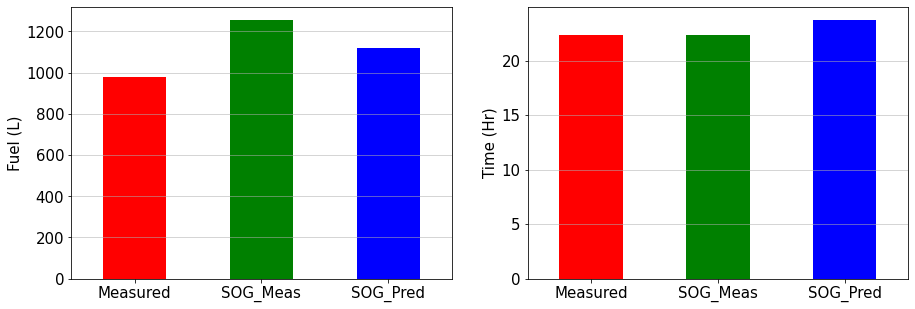

In [50]:
df_st_rt = pd.concat([df_st_rt1, df_st_rt3, df_st_rt2], axis=1) 

fig, ax = plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
df_st_rt.T['fuel'].plot.bar(color=['red', 'green', 'blue', ])
plt.grid(axis='y', alpha=0.65)
plt.ylabel('Fuel (L)', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=0, fontsize=15)

plt.subplot(1,2,2)
df_st_rt.T['time'].plot.bar(color=['red', 'green', 'blue', ])
plt.grid(axis='y', alpha=0.65)
plt.ylabel('Time (Hr)', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=0, fontsize=15) 

plt.subplots_adjust(wspace=0.2)

# plt.tight_layout()
# plt.savefig(Output_folder+'/Barplots_FL_Time_Seq2SeqReg'+file_nm_ext+'.png', dpi=300)

plt.show()  

In [51]:
improve_fuel=(df_st_rt.T.fuel-df_st_rt.SOG_Pred.fuel)/df_st_rt.T.fuel*100
improve_fuel

Measured   -14.319103
SOG_Meas    10.997012
SOG_Pred     0.000000
Name: fuel, dtype: float64

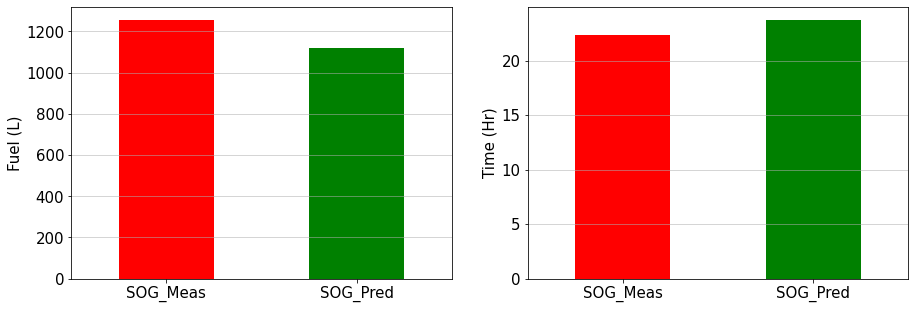

In [52]:
df_st_rt = pd.concat([df_st_rt3, df_st_rt2], axis=1) 

fig, ax = plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
df_st_rt.T['fuel'].plot.bar(color=['red', 'green', 'blue', ])
plt.grid(axis='y', alpha=0.65)
plt.ylabel('Fuel (L)', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=0, fontsize=15)

plt.subplot(1,2,2)
df_st_rt.T['time'].plot.bar(color=['red', 'green', 'blue', ])
plt.grid(axis='y', alpha=0.65)
plt.ylabel('Time (Hr)', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=0, fontsize=15) 

plt.subplots_adjust(wspace=0.2)

# plt.tight_layout()
plt.savefig(Output_folder+'/Barplots_FL_Time_Seq2SeqReg'+file_nm_ext+'.png', dpi=300)

plt.show()  

In [53]:
improve_fuel=(df_st_rt.T.fuel-df_st_rt.SOG_Pred.fuel)/df_st_rt.T.fuel*100
print('improve_fuel=\n',improve_fuel)
print('')
improve_time=(df_st_rt.T.time-df_st_rt.SOG_Pred.time)/df_st_rt.T.time*100
print('improve_time=\n',improve_time)

improve_fuel=
 SOG_Meas    10.997012
SOG_Pred     0.000000
Name: fuel, dtype: float64

improve_time=
 SOG_Meas   -6.414048
SOG_Pred    0.000000
Name: time, dtype: float64


In [54]:
# df_res=pd.DataFrame({'Sog_Mease':df_stats3.T})
# df_res
df_st_rt['improv']=(df_st_rt.SOG_Meas-df_st_rt.SOG_Pred)/df_st_rt.SOG_Meas*100
display(df_st_rt.round(2))

df_st_rt.round(2).to_excel(Output_folder+'/Results_'+str(Eff_limit_fg)+'_inp_'+str(var_inputs)+'_lag_'+str(lag_test)+'.xlsx')


,SOG_Meas,SOG_Pred,improv
fuel,1256.62,1118.43,11.00
time,22.32,23.75,-6.41
distance,349.20,336.28,3.70
sog_avg,1.67,1.57,5.56


In [55]:
# st=stop

In [56]:
print('seq_idx=', seq_idx)

seq_idx= 5


In [57]:
df[["speedOverGround","speedApparent"]].describe()

,speedOverGround,speedApparent
count,10665.000000,10665.000000
mean,3.476405,7.343194
std,1.216466,3.930607
min,0.503725,0.080349
25%,2.793400,4.379857
50%,3.914775,6.795093
75%,4.330200,9.704185
max,5.954200,31.113290


In [58]:
end_time_all = time.time()
elapsed_time_all = end_time_all - start_time_all
print(f"Time taken: {elapsed_time_all} seconds")

Time taken: 52.78647232055664 seconds


In [59]:
print(X[:,:, 0].max())
print(X[:,:, 1].max())

2.2546844
2.1072226


In [60]:
nth_mid_sth_fg

'Cruising_Speeds'

In [61]:
gr_ock_fg

1

In [62]:
Reg_Mod_inps

5

In [63]:
var_inputs

12

In [64]:
Eff_limit_combs

['Top10']

In [65]:
lag_test

1

In [66]:
len(rt_id_train)

82

In [67]:
# Simi_dict

In [68]:
display(df_st_rt.round(2))

,SOG_Meas,SOG_Pred,improv
fuel,1256.62,1118.43,11.00
time,22.32,23.75,-6.41
distance,349.20,336.28,3.70
sog_avg,1.67,1.57,5.56


In [69]:
###Time taken: 124.30116391181946 seconds
print(f"Time taken: {elapsed_time_all} seconds")

Time taken: 52.78647232055664 seconds


In [70]:
# print(Simi_dict)

In [71]:
# st=stop


## Some Selected Plots

In [72]:
seq_idx

5

In [73]:
### from Selected_Plots_HMM_WeathLag26_Cruis_SOG_v2.ipynb  ###
most_likely_states = np.array([1, 1, 1, 1, 2, 2, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 1, 1, 2, 0, 0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 1, 2, 0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1], dtype=int)


In [74]:
sorted_weather_states={2: 'calm_weather', 1: 'moderate_weather', 0: 'extrem_weather'}

In [75]:
# states_to_sog_indexes
# sog_opt_avg
most_likely_states

array([1, 1, 1, 1, 2, 2, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0,
       0, 1, 2, 0, 1, 1, 1, 2, 0, 0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 1, 2,
       0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 2, 0, 2, 2,
       0, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 2, 0, 1, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0,
       2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0, 2,
       0, 0, 0, 1, 2, 2, 2, 1])

In [76]:
# seq_idx=0
# seq_idx=1
# seq_idx=2
# seq_idx=3
# seq_idx=4
# seq_idx=5
# seq_idx=6
# seq_idx=7
# seq_idx=8
# seq_idx=9
seq_idx=10
# seq_idx=11
# seq_idx=12

# seq_idx=25

# seq_idx=97



print('seq_idx=', seq_idx)
print('weather_state=', sorted_weather_states[most_likely_states[seq_idx]])
print('RT_id=', dfnew.RT_id.unique()[seq_idx])

seq_idx= 10
weather_state= extrem_weather
RT_id= 1034


In [77]:
df_sog_fuel=dfnew.round(2) 
df_sog_fuel['fuel_sog_pred']=y_pred7.reshape(-1).round(2) 
df_sog_fuel['fuel_sog_meas']=y_pred7_sog_meas.reshape(-1).round(2) 

df_filter=df_sog_fuel[(dfnew['RT_id'] == df_sog_fuel.RT_id.unique()[seq_idx]) & (df_sog_fuel['speedOverGround'] > 0)][['RT_id','distance', 'speedOverGround', 'sog_pred', 'fuel_sog_meas', 'fuel_sog_pred']]
print(df_filter.shape)
print((df_sog_fuel[['fuel_sog_meas', 'fuel_sog_pred']]/(60)).sum())


fuel_stats = (df_filter[['fuel_sog_meas', 'fuel_sog_pred']]/(60)).sum().round(2) 

print('Fuel_meas=', fuel_stats.fuel_sog_meas)
print('Fuel_pred=', fuel_stats.fuel_sog_pred)

(14, 6)
fuel_sog_meas    1256.611084
fuel_sog_pred    1118.424561
dtype: float32
Fuel_meas= 6.22
Fuel_pred= 4.5


In [78]:
sog_small_idx=(df_filter['speedOverGround']< 0.1)
df_filter.loc[sog_small_idx, ['speedOverGround', 'distance']] = 0
time_i=df_filter.distance/df_filter['speedOverGround']*1000/3600

time_i=time_i.replace(np.inf,0)
time_i=time_i.replace(np.nan,0)
Time_meas=round(time_i.sum()*60,2)

sog_small_idx=(df_filter['sog_pred']< 0.1)
df_filter.loc[sog_small_idx, ['sog_pred', 'distance']] = 0
time_i=df_filter.distance/df_filter['sog_pred']*1000/3600

# time_i=time_i.replace(np.inf,0)
# time_i=time_i.replace(np.nan,0)
Time_pred=round(time_i.sum()*60,2)


Total_time_meas = Time_meas  
Total_time_pred = Time_pred  

print('Total_time_meas=', Total_time_meas, 'min')
print('Total_time_pred=', Total_time_pred, 'min')

Total_time_meas= 13.42 min
Total_time_pred= 15.68 min


In [79]:
model_name = Output_folder_main.split('_')[0]
model_name

'KNN'

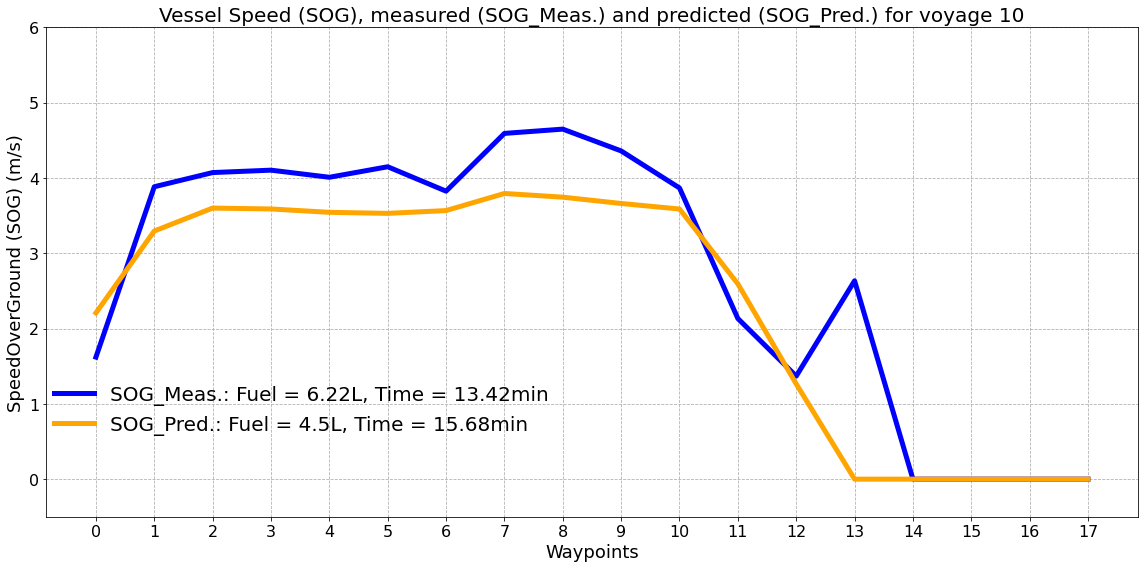

In [80]:
# Plot
Waypts = 18

if tempo_res == '1min':
    tm = '(Min.)'
if tempo_res == '1S':
    tm = '(Sec.)'

Ypred2 = y_pred2.reshape(-1)
Ytest2 = Y_test2[:, 0]

fig, ax1 = plt.subplots(figsize=(16, 8))

x_ticks = np.arange(0, Waypts)

# Offset the position of the new axis
offset = 60  # Adjust the offset as needed to avoid overlapping
# ax3.spines['right'].set_position(('outward', offset))

ax1.plot(x_ticks, YTest1[seq_idx, 0:Waypts], 'b', label="SOG_Meas.: "+"Fuel = "+str(fuel_stats.fuel_sog_meas)+"L"
         +", Time = "+str(Total_time_meas)+"min", linewidth=5)

ax1.plot(x_ticks,YPred1[seq_idx, 1:Waypts + 1], 'orange', label="SOG_Pred.: "+"Fuel = "+str(fuel_stats.fuel_sog_pred)+"L"
         +", Time = "+str(Total_time_pred)+"min", linewidth=5)



plt.xticks(x_ticks)


plt.title('Vessel Speed (SOG), measured (SOG_Meas.) and predicted (SOG_Pred.) for voyage '+str(seq_idx),  fontsize=20)

ax1.set_xlabel('Waypoints', fontsize=18)
ax1.set_ylabel('SpeedOverGround (SOG) (m/s)', fontsize=18)


ax1.tick_params(axis='y', labelsize=16) 
ax1.tick_params(axis='x', labelsize=16) 

ax1.set_ylim(-0.5, 6)


ax1.legend(loc="lower left", bbox_to_anchor=(0.0, 0.15), ncol=1, borderaxespad=0, frameon=False, fontsize=20)

ax1.grid(linestyle='--')

ax1.grid(which='minor', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(Output_folder+'/Fig_'+model_name+'_SOG_EFFscore_seq'+str(seq_idx)+'_Weathers'+'.png', dpi=500)


plt.show()  


In [81]:
# st=stop

In [82]:
print(dforig.shape)
df.columns
df[['fuel_total', 'time_total']].max()

(39193, 71)


fuel_total    12.922370
time_total    29.567607
dtype: float64

In [83]:
print('Fuel_meas=', fuel_stats.fuel_sog_meas)
print('Fuel_pred=', fuel_stats.fuel_sog_pred)
print('Total_time_meas=', Total_time_meas, 'min')
print('Total_time_pred=', Total_time_pred, 'min')

fl_meas_norm=fuel_stats.fuel_sog_meas/df['fuel_total'].max()
fl_pred_norm=fuel_stats.fuel_sog_pred/df['fuel_total'].max()

tm_meas_norm=Total_time_meas/df['time_total'].max()
tm_pred_norm=Total_time_pred/df['time_total'].max()

eff_meas_seq=1-(2*(fl_meas_norm*tm_meas_norm)/(fl_meas_norm+tm_meas_norm))
eff_pred_seq=1-(2*(fl_pred_norm*tm_pred_norm)/(fl_pred_norm+tm_pred_norm))

print('eff_meas for seq'+str(seq_idx)+'=', eff_meas_seq)
print('eff_pred for seq'+str(seq_idx)+'=', eff_pred_seq)

print()
print('eff_meas for seq'+str(seq_idx)+'=', round(eff_meas_seq,2))
print('eff_pred for seq'+str(seq_idx)+'=', round(eff_pred_seq,2))

Fuel_meas= 6.22
Fuel_pred= 4.5
Total_time_meas= 13.42 min
Total_time_pred= 15.68 min
eff_meas for seq10= 0.5327977080906545
eff_pred for seq10= 0.5795958540926252

eff_meas for seq10= 0.53
eff_pred for seq10= 0.58


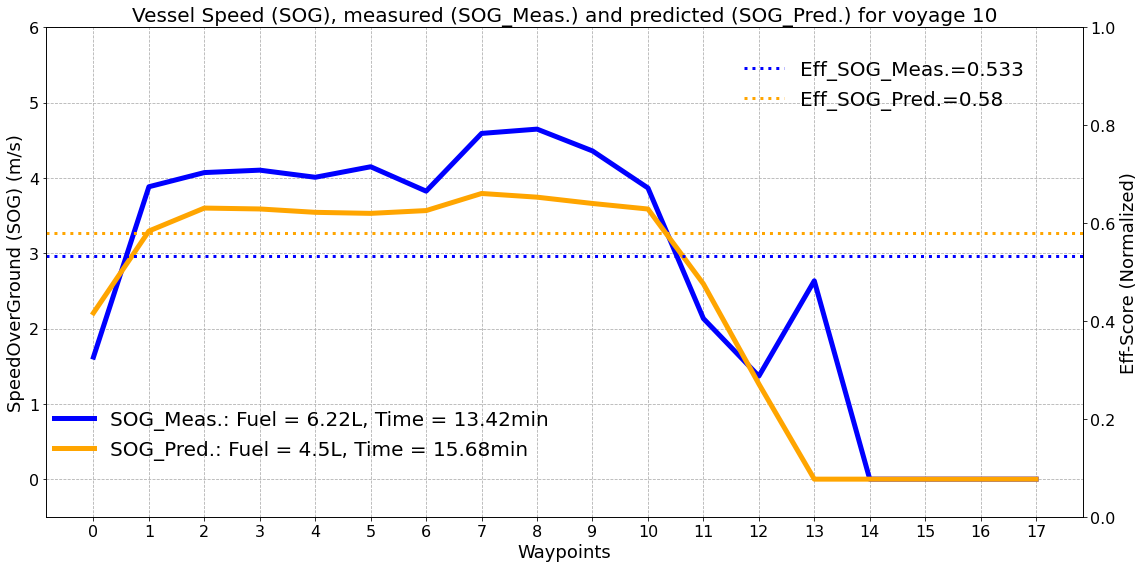

In [84]:
# Plot
Waypts = 18

if tempo_res == '1min':
    tm = '(Min.)'
if tempo_res == '1S':
    tm = '(Sec.)'

Ypred2 = y_pred2.reshape(-1)
Ytest2 = Y_test2[:, 0]

fig, ax1 = plt.subplots(figsize=(16, 8))

x_ticks = np.arange(0, Waypts)
ax2 = ax1.twinx()

# Offset the position of the new axis
offset = 60  # Adjust the offset as needed to avoid overlapping
# ax3.spines['right'].set_position(('outward', offset))

ax1.plot(x_ticks, YTest1[seq_idx, 0:Waypts], 'b', label="SOG_Meas.: "+"Fuel = "+str(fuel_stats.fuel_sog_meas)+"L"
         +", Time = "+str(Total_time_meas)+"min", linewidth=5)

ax1.plot(x_ticks,YPred1[seq_idx, 1:Waypts + 1], 'orange', label="SOG_Pred.: "+"Fuel = "+str(fuel_stats.fuel_sog_pred)+"L"
         +", Time = "+str(Total_time_pred)+"min", linewidth=5)


ax2.axhline(y=eff_meas_seq, color='b', linestyle=':', label="Eff_SOG_Meas.=" + str(round(eff_meas_seq, 3)), linewidth=3)
ax2.axhline(y=eff_pred_seq, color='orange', linestyle=':', label="Eff_SOG_Pred.=" + str(round(eff_pred_seq, 3)), linewidth=3)

ax2.legend(loc="upper right", bbox_to_anchor=(0.95, 0.95), ncol=1, borderaxespad=0, frameon=False, fontsize=20)


plt.xticks(x_ticks)


plt.title('Vessel Speed (SOG), measured (SOG_Meas.) and predicted (SOG_Pred.) for voyage '+str(seq_idx),  fontsize=20)

ax1.set_xlabel('Waypoints', fontsize=18)
ax1.set_ylabel('SpeedOverGround (SOG) (m/s)', fontsize=18)
ax2.set_ylabel('Eff-Score (Normalized)', fontsize=18)


ax1.tick_params(axis='y', labelsize=16) 
ax1.tick_params(axis='x', labelsize=16) 
ax2.tick_params(axis='y', labelsize=16) 


ax1.set_ylim(-0.5, 6)
ax2.set_ylim(0, 1)



ax1.legend(loc="lower left", bbox_to_anchor=(0.0, 0.10), ncol=1, borderaxespad=0, frameon=False, fontsize=20)

ax1.grid(linestyle='--')

ax1.grid(which='minor', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(Output_folder+'/Fig_'+model_name+'_Line_EFFscore_SOG_seq'+str(seq_idx)+'_Weathers'+'.png', dpi=500)


plt.show()  


In [85]:
# st=stop

## Plot Voyage using Bokeh

In [86]:
seq_bokeh=seq_idx
seq_bokeh

10

In [87]:
print(len(df_sog_fuel.RT_id.unique()))
vog_id= df_sog_fuel.RT_id.unique()[seq_bokeh]
print(vog_id)
# print(df_sog_fuel.columns)

df_voyage_allsog=dforig[(dforig['RT_id'] == vog_id)][['date', 'RT_id', 'longitude', 'latitude', 'distance', 'speedOverGround']]
df_voyage_allsog['sog_meas']=df_voyage_allsog['speedOverGround']
df_voyage_allsog['sog_pred']=df_voyage_allsog['speedOverGround']
df_voyage_allsog = df_voyage_allsog.drop(columns=['speedOverGround'])

df_sog_fuel[df_sog_fuel.RT_id==seq_bokeh]
df_voyage=df_sog_fuel[(df_sog_fuel['RT_id'] == vog_id) & (df_sog_fuel['speedOverGround'] > 0)][[ 'date','RT_id', 'longitude', 'latitude', 'distance', 'speedOverGround', 'sog_pred', 'fuel_sog_meas', 'fuel_sog_pred']]

# df_voyage
print(df_voyage_allsog.shape)
print(df_voyage.shape)
print(df_sog_fuel.shape)

162
1034
(24, 7)
(14, 9)
(4374, 80)


In [88]:
# Ensure that both DataFrames have 'date' as the index
df_voyage_allsog['date'] = pd.to_datetime(df_voyage_allsog['date'])
df_voyage['date'] = pd.to_datetime(df_voyage['date'])

# Set 'date' as the index for both DataFrames
df_voyage_allsog.set_index('date', inplace=True)
df_voyage.set_index('date', inplace=True)

# Update 'sog_pred' in df_voyage_allsog with values from df_voyage for matching dates
df_voyage_allsog['sog_pred'] = df_voyage['sog_pred']

df_voyage_allsog['sog_pred'].fillna(df_voyage_allsog['sog_meas'], inplace=True)

# Reset the index if needed
df_voyage_allsog.reset_index(inplace=True)
# df_voyage_allsog

In [89]:
# Assuming 'date' is already in datetime format
df_voyage_allsog['date'] = pd.to_datetime(df_voyage_allsog['date'])

# Set 'date' as the index of the DataFrame
df_voyage_allsog.set_index('date', inplace=True)

# Resample to 1-second intervals and interpolate
df_voyg_resm = df_voyage_allsog.resample('1S').asfreq()
df_voyg_resm = df_voyg_resm.interpolate(method='linear')

df_voyg_resm.RT_id=df_voyg_resm.RT_id[0]
# Reset the index to make 'date' a regular column again
df_voyg_resm.reset_index(inplace=True)
df_voyg_resm = df_voyg_resm.drop(columns=['date'])
df_voyg_resm.shape

(1801, 6)

In [90]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, ColumnDataSource
# from bokeh.tile_providers import get_provider, Vendors
from bokeh.tile_providers import get_provider, Vendors, WIKIMEDIA, CARTODBPOSITRON, STAMEN_TERRAIN, STAMEN_TONER, ESRI_IMAGERY, OSM

from bokeh.palettes import PRGn, RdYlGn
from bokeh.transform import linear_cmap,factor_cmap
from bokeh.layouts import row, column
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
##############################################################################################

# Define function to switch from lat/long to mercator coordinates
def x_coord(x, y):
    
    lat = x
    lon = y
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return (x, y)
###################################################
output_notebook()

# var2='EngineFuelRate'; bar_title='          EngineFuelRate (Volume/Time)'
var2='sog_pred'; bar_title='    SpeedOverGround, (SOG_Meas, m/s)'

# var2='EngineSpeed'; bar_title='                  EngineSpeed (rpm)'


dfloc=df_voyg_resm

        
dfloc['coordinates'] = list(zip(dfloc['latitude'], dfloc['longitude']))

# Obtain list of mercator coordinates
mercators = [x_coord(x, y) for x, y in dfloc['coordinates']]
# Create mercator column in our df
dfloc['mercator'] = mercators

# Split that column out into two separate cols - mercator_x and mercator_y
dfloc[['mercator_x', 'mercator_y']] = dfloc['mercator'].apply(pd.Series)

####################################################

# Select tile set to use
#     chosentile = get_provider(Vendors.STAMEN_TERRAIN)
# chosentile = get_provider(Vendors.WIKIMEDIA)
chosentile = get_provider(WIKIMEDIA)

# Choose palette
# palette = PRGn[11]
# palette = PRGn[8]
from bokeh.palettes import Plasma256
palette=Plasma256

# Tell Bokeh to use df as the source of the data
source = ColumnDataSource(data=dfloc)

# Define color mapper - which column will define the colour of the data points
color_mapper = linear_cmap(field_name = var2, palette = palette, low = dfloc[var2].min(), high = dfloc[var2].max())

color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                    formatter = NumeralTickFormatter(format='0.0[0000]'), 
                    label_standoff=2, width=8, location=(0,0), title=bar_title)
color_bar.major_label_text_font_size = '16pt'  # Set the desired font size here
color_bar.title_text_font_size = '20pt'  # Set the desired font size here
color_bar.title_standoff =-170  # Set the desired title standoff value here

# q = figure(title ='Voyage: '+str(seq_bokeh) +".   SOG_Meas.,               Eff_Meas.=" + str(round(eff_meas_seq, 3))
#            +" \n Fuel = "+str(fuel_stats.fuel_sog_meas)+"L"
#            +", Time = "+str(Total_time_meas)+"min",
#            +", Eff_Pred.=" + str(round(eff_meas_seq, 3))
#             x_axis_type="mercator", y_axis_type="mercator", 
#             x_axis_label = 'Longitude', y_axis_label = 'Latitude')

q = figure(title ='Voyage: '+str(seq_bokeh) +",                         Eff_SOG_Meas.=" + str(round(eff_meas_seq, 3)),
            x_axis_type="mercator", y_axis_type="mercator", 
            x_axis_label = 'Longitude', y_axis_label = 'Latitude')


# Change the title font size
q.title.text_font_size = "14pt"  # You can specify the desired font size

q.add_layout(color_bar, 'right')

q.circle(x = 'mercator_x', y = 'mercator_y', line_color=color_mapper, color = color_mapper, source=source, size=5, fill_color= color_mapper, fill_alpha =0.7)

q.add_tile(chosentile)
   

# show(q)

# Save the plot to an HTML file without displaying it
from bokeh.io import output_file, save
output_file(Output_folder+'/Fig_Measured_Voyage_EFFscore_SOG_seq'+str(seq_idx)+'_Weathers'+'.html')
save(q)


Loading BokehJS ...

'C:\\Users\\mohabu\\iHelm\\CTs4_TSA\\KNN_Weathers_v1\\SampLSTM_32\\NMS_Cruising_Speeds\\EffTp_Top10\\GrOck_1_loc__inps_12_lag_1\\Fig_Measured_Voyage_EFFscore_SOG_seq10_Weathers.html'

In [91]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, ColumnDataSource
# from bokeh.tile_providers import get_provider, Vendors
from bokeh.tile_providers import get_provider, Vendors, WIKIMEDIA, CARTODBPOSITRON, STAMEN_TERRAIN, STAMEN_TONER, ESRI_IMAGERY, OSM

from bokeh.palettes import PRGn, RdYlGn
from bokeh.transform import linear_cmap,factor_cmap
from bokeh.layouts import row, column
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
##############################################################################################

# Define function to switch from lat/long to mercator coordinates
def x_coord(x, y):
    
    lat = x
    lon = y
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return (x, y)
###################################################
output_notebook()

# var2='EngineFuelRate'; bar_title='          EngineFuelRate (Volume/Time)'
var2='sog_pred'; bar_title='    SpeedOverGround, (SOG_Pred, m/s)'

# var2='EngineSpeed'; bar_title='                  EngineSpeed (rpm)'


dfloc=df_voyg_resm

        
dfloc['coordinates'] = list(zip(dfloc['latitude'], dfloc['longitude']))

# Obtain list of mercator coordinates
mercators = [x_coord(x, y) for x, y in dfloc['coordinates']]
# Create mercator column in our df
dfloc['mercator'] = mercators

# Split that column out into two separate cols - mercator_x and mercator_y
dfloc[['mercator_x', 'mercator_y']] = dfloc['mercator'].apply(pd.Series)

####################################################

# Select tile set to use
#     chosentile = get_provider(Vendors.STAMEN_TERRAIN)
# chosentile = get_provider(Vendors.WIKIMEDIA)
chosentile = get_provider(WIKIMEDIA)

# Choose palette
# palette = PRGn[11]
# palette = PRGn[8]
from bokeh.palettes import Plasma256
palette=Plasma256

# Tell Bokeh to use df as the source of the data
source = ColumnDataSource(data=dfloc)

# Define color mapper - which column will define the colour of the data points
color_mapper = linear_cmap(field_name = var2, palette = palette, low = dfloc[var2].min(), high = dfloc[var2].max())

color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                    formatter = NumeralTickFormatter(format='0.0[0000]'), 
                    label_standoff=2, width=8, location=(0,0), title=bar_title)
color_bar.major_label_text_font_size = '16pt'  # Set the desired font size here
color_bar.title_text_font_size = '20pt'  # Set the desired font size here
color_bar.title_standoff =-170  # Set the desired title standoff value here


# q = figure(title ='Voyage: '+str(seq_bokeh) +".   SOG_Pred.,               Eff_Meas.=" + str(round(eff_meas_seq, 3))
#            +" \n Fuel = "+str(fuel_stats.fuel_sog_pred)+"L"
#            +", Time = "+str(Total_time_pred)+"min"
#            +",     Eff_Pred.=" + str(round(eff_pred_seq, 3)),
#             x_axis_type="mercator", y_axis_type="mercator", 
#             x_axis_label = 'Longitude', y_axis_label = 'Latitude')


# q2 = figure(title ='Voyage: '+str(seq_bokeh) +",                         Eff_SOG_Meas.=" + str(round(eff_meas_seq, 3))
#            +" \n                                             Eff_SOG_Pred.=" + str(round(eff_pred_seq, 3)),
#             x_axis_type="mercator", y_axis_type="mercator", 
#             x_axis_label = 'Longitude', y_axis_label = 'Latitude')

q2 = figure(title=f'Voyage: {seq_bokeh},                           Eff_SOG_Meas={eff_meas_seq:.3f} \n                                               Eff_SOG_Pred={eff_pred_seq:.3f}',
            x_axis_type="mercator", y_axis_type="mercator",
            x_axis_label='Longitude', y_axis_label='Latitude')


# Change the title font size
q2.title.text_font_size = "14pt"  # You can specify the desired font size

q2.add_layout(color_bar, 'right')

q2.circle(x = 'mercator_x', y = 'mercator_y', line_color=color_mapper, color = color_mapper, source=source, size=5, fill_color= color_mapper, fill_alpha =0.7)

q2.add_tile(chosentile)
   

# show(q2)

# Save the plot to an HTML file without displaying it
from bokeh.io import output_file, save
output_file(Output_folder+'/Fig_'+model_name+'_Voyage_EFFscore_SOG_seq'+str(seq_idx)+'_Weathers'+'.html')
save(q2)


Loading BokehJS ...

'C:\\Users\\mohabu\\iHelm\\CTs4_TSA\\KNN_Weathers_v1\\SampLSTM_32\\NMS_Cruising_Speeds\\EffTp_Top10\\GrOck_1_loc__inps_12_lag_1\\Fig_KNN_Voyage_EFFscore_SOG_seq10_Weathers.html'

In [92]:
# st=stop

## Caclulate Eff-meas and Eff-pred for test dataset

In [93]:
len(rt_id_test)

162

In [94]:
df_90 = pd.read_excel('TSA_Results/Top10_LSTM_DTW_KNN_HMM.xlsx')

In [95]:
df_eff_test = pd.DataFrame(columns=['Voyage','Weather_State', 'Weather_String',
                                    'fuel_meas', 'time_meas', 'eff_meas',
                                    'fuel_pred', 'time_pred', 'eff_pred'])

df_sog_fuel=dfnew.round(2) 
df_sog_fuel['fuel_sog_pred']=y_pred7.reshape(-1).round(2) 
df_sog_fuel['fuel_sog_meas']=y_pred7_sog_meas.reshape(-1).round(2) 


for voyag_id in rt_id_test:
    w_st = df_90.loc[df_90['Voyage'] == voyag_id, 'Weather_State'].values[0]
    w_str = df_90.loc[df_90['Voyage'] == voyag_id, 'Weather_String'].values[0]
    df_sog_fuel=dfnew.round(2) 
    df_filter=df_sog_fuel[(dfnew['RT_id'] == voyag_id) & (df_sog_fuel['speedOverGround'] > 0)][['RT_id','distance', 'speedOverGround', 'sog_pred', 'fuel_sog_meas', 'fuel_sog_pred']]
    fuel_stats = (df_filter[['fuel_sog_meas', 'fuel_sog_pred']]/(60)).sum().round(2) 

    sog_small_idx=(df_filter['speedOverGround']< 0.1)
    df_filter.loc[sog_small_idx, ['speedOverGround', 'distance']] = 0
    time_i=df_filter.distance/df_filter['speedOverGround']*1000/3600

    time_i=time_i.replace(np.inf,0)
    time_i=time_i.replace(np.nan,0)
    Time_meas=round(time_i.sum()*60,2)

    sog_small_idx=(df_filter['sog_pred']< 0.1)
    df_filter.loc[sog_small_idx, ['sog_pred', 'distance']] = 0
    time_i=df_filter.distance/df_filter['sog_pred']*1000/3600

    time_i=time_i.replace(np.inf,0)
    time_i=time_i.replace(np.nan,0)
    Time_pred=round(time_i.sum()*60,2)

    Total_time_meas = Time_meas  
    Total_time_pred = Time_pred  

    df[['fuel_total', 'time_total']].max()

    fl_meas_norm=fuel_stats.fuel_sog_meas/df['fuel_total'].max()
    fl_pred_norm=fuel_stats.fuel_sog_pred/df['fuel_total'].max()

    tm_meas_norm=Total_time_meas/df['time_total'].max()
    tm_pred_norm=Total_time_pred/df['time_total'].max()

    eff_meas_seq=1-(2*(fl_meas_norm*tm_meas_norm)/(fl_meas_norm+tm_meas_norm))
    eff_pred_seq=1-(2*(fl_pred_norm*tm_pred_norm)/(fl_pred_norm+tm_pred_norm))
    
#     print('Voyag_id=', voyag_id)

    df_eff_test = df_eff_test.append({'Voyage': voyag_id, 'Weather_State':w_st, 'Weather_String':w_str,
                                      'fuel_meas':fuel_stats.fuel_sog_meas, 'fuel_pred':fuel_stats.fuel_sog_pred,
                                      'time_meas':Total_time_meas, 'time_pred':Total_time_pred,
                                      'eff_meas': eff_meas_seq, 'eff_pred': eff_pred_seq}, ignore_index=True)
    


# Assuming df_eff_test is your existing DataFrame
df_eff_test['eff_diff'] = df_eff_test['eff_pred'] - df_eff_test['eff_meas']
df_eff_test['eff_gain'] = (df_eff_test['eff_diff'] / df_eff_test['eff_meas']) * 100


# Calculate the sum and mean for each column
sum_row = df_eff_test[['Voyage', 'Weather_State', 'Weather_String', 'fuel_meas','time_meas','eff_meas','fuel_pred','time_pred','eff_pred', 'eff_diff', 'eff_gain']].sum()
avg_row = df_eff_test[['Voyage', 'Weather_State', 'Weather_String', 'fuel_meas','time_meas','eff_meas','fuel_pred','time_pred','eff_pred', 'eff_diff', 'eff_gain']].mean()

sum_row['Weather_String'] = 'Total'
avg_row['Weather_String']=df_eff_test['Weather_String'].mode()[0]

# Create DataFrames for the sum and mean rows
sum_df = pd.DataFrame(sum_row).T
avg_df = pd.DataFrame(avg_row).T

# Set the index for the sum and mean DataFrames
sum_df.index = ['sum']
avg_df.index = ['avg']

# Concatenate the sum and mean DataFrames with the sorted DataFrame
df_eff_test_sum_avg = pd.concat([df_eff_test, sum_df, avg_df])

# print(df_eff_test_sum_avg.head())

df_eff_test_sum_avg.to_excel(Output_folder+'/Eff_test_meas_pred_'+str(Eff_limit_fg)+'_inp_'+str(var_inputs)+'_lag_'+str(lag_test)+'.xlsx')
df_eff_test_sum_avg.to_excel('Stats_Counts_v1/Results'+'/'+model_name+'_Eff_test_meas_pred_'+str(Eff_limit_fg)+'.xlsx')


# Sort the DataFrame based on the "eff_gain" column
df_sorted_eff_test = df_eff_test.sort_values(by='eff_gain', ascending=False)

df_sorted_eff_test['orig_index'] = df_sorted_eff_test.index

# If you want to reset the index of the sorted DataFrame
df_sorted_eff_test = df_sorted_eff_test.reset_index(drop=True)

# Concatenate the sum and mean DataFrames with the sorted DataFrame
df_sorted_eff_test_sum_avg = pd.concat([df_sorted_eff_test, sum_df, avg_df])


# print(df_sorted_eff_test_sum_avg.head())

df_sorted_eff_test_sum_avg.to_excel(Output_folder+'/Sorted_Eff_test_meas_pred_'+str(Eff_limit_fg)+'_inp_'+str(var_inputs)+'_lag_'+str(lag_test)+'.xlsx')
df_sorted_eff_test_sum_avg.to_excel('Stats_Counts_v1/Results'+'/'+model_name+'_Sorted_Eff_test_meas_pred_'+str(Eff_limit_fg)+'.xlsx')


print(df_sorted_eff_test_sum_avg.tail(2))


         Voyage Weather_State   Weather_String fuel_meas  time_meas  eff_meas  \
sum      102540         149.0            Total    893.75    1926.27  95.67018   
avg  632.962963      0.919753  extreme_weather  5.516976  11.890556  0.590557   

      fuel_pred  time_pred   eff_pred  eff_diff    eff_gain  orig_index  
sum  789.200012    2067.23  97.609579  1.939399  345.179702         NaN  
avg    4.871606  12.760679   0.602528  0.011972    2.130739         NaN  


In [96]:
# df_eff_test
# df_sorted_eff_test
df_sorted_eff_test_sum_avg.tail(2)

,Voyage,Weather_State,Weather_String,fuel_meas,time_meas,eff_meas,fuel_pred,time_pred,eff_pred,eff_diff,eff_gain,orig_index
sum,102540,149.0,Total,893.75,1926.27,95.67018,789.200012,2067.23,97.609579,1.939399,345.179702,NaN
avg,632.962963,0.919753,extreme_weather,5.516976,11.890556,0.590557,4.871606,12.760679,0.602528,0.011972,2.130739,NaN


In [97]:
# Create a DataFrame df_counts
df_counts = pd.DataFrame(columns=['Improved_Fuel_Vs', 'Not_Improved_Fuel_Vs', 'Improved_Time_Vs', 'Not_Improved_Time_Vs', 'Improved_Eff_Vs', 'Not_Improved_Eff_Vs'])

# Calculate counts for improved conditions
improved_fuel_vs = (df_eff_test['fuel_pred'] < df_eff_test['fuel_meas']).sum()
improved_time_vs = (df_eff_test['time_pred'] < df_eff_test['time_meas']).sum()
improved_eff_vs = (df_eff_test['eff_pred'] > df_eff_test['eff_meas']).sum()

# Calculate counts for not improved conditions
not_improved_fuel_vs = len(df_eff_test) - improved_fuel_vs
not_improved_time_vs = len(df_eff_test) - improved_time_vs
not_improved_eff_vs = len(df_eff_test) - improved_eff_vs

# Calculate percentages
total_voyages = len(df_eff_test)
percentage_improved_fuel = round(improved_fuel_vs / total_voyages,2)*100
percentage_not_improved_fuel = round(not_improved_fuel_vs / total_voyages,2)*100
percentage_improved_time = round(improved_time_vs / total_voyages,2)*100
percentage_not_improved_time = round(not_improved_time_vs / total_voyages,2)*100
percentage_improved_eff = round(improved_eff_vs / total_voyages,2)*100
percentage_not_improved_eff = round(not_improved_eff_vs / total_voyages,2)*100

# Add rows to df_counts
df_counts = df_counts.append({'Improved_Fuel_Vs': improved_fuel_vs, 'Not_Improved_Fuel_Vs': not_improved_fuel_vs,
                              'Improved_Time_Vs': improved_time_vs, 'Not_Improved_Time_Vs': not_improved_time_vs,
                              'Improved_Eff_Vs': improved_eff_vs, 'Not_Improved_Eff_Vs': not_improved_eff_vs}, ignore_index=True)
df_counts = df_counts.append({'Improved_Fuel_Vs': percentage_improved_fuel, 'Not_Improved_Fuel_Vs': percentage_not_improved_fuel,
                              'Improved_Time_Vs': percentage_improved_time, 'Not_Improved_Time_Vs': percentage_not_improved_time,
                              'Improved_Eff_Vs': percentage_improved_eff, 'Not_Improved_Eff_Vs': percentage_not_improved_eff}, ignore_index=True)

# Set index names
df_counts.index = ['Count', 'Percentage']


df_counts.to_excel(Output_folder+'/Counts_Eff_Test_Perc_'+str(Eff_limit_fg)+'_inp_'+str(var_inputs)+'_lag_'+str(lag_test)+'.xlsx')

df_counts.to_excel('Stats_Counts_v1/Results'+'/'+model_name+'Counts_Perc_Eff_Test_'+str(Eff_limit_fg)+'.xlsx')

# Display df_counts
df_counts


,Improved_Fuel_Vs,Not_Improved_Fuel_Vs,Improved_Time_Vs,Not_Improved_Time_Vs,Improved_Eff_Vs,Not_Improved_Eff_Vs
Count,141,21,19,143,114,48
Percentage,87.0,13.0,12.0,88.0,70.0,30.0


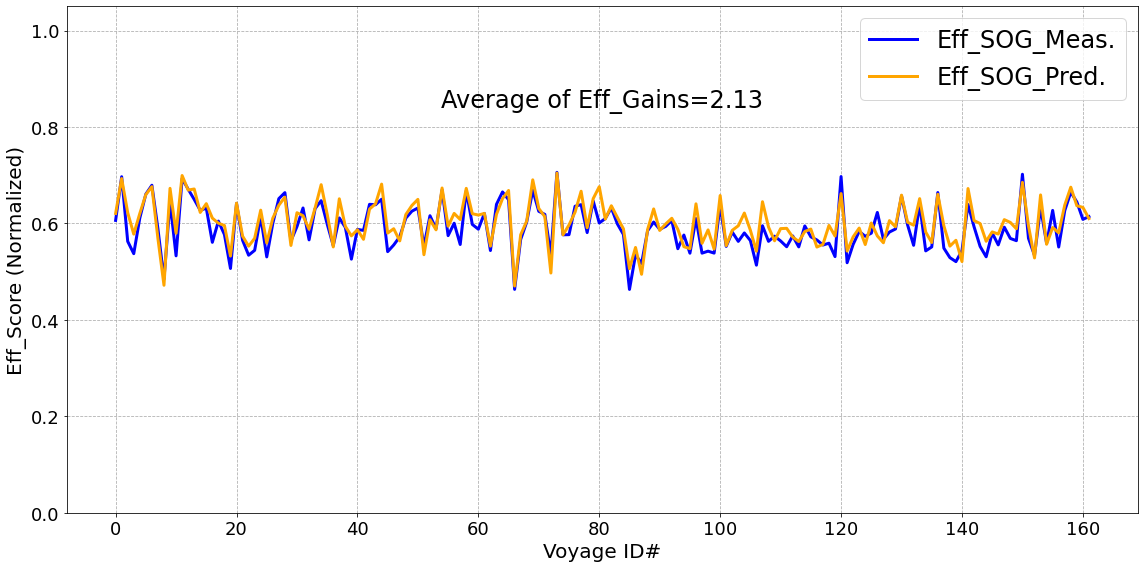

In [98]:
####Plot

plt.figure(figsize=(16,8))

plt.plot(df_eff_test.eff_meas, label="Eff_SOG_Meas.", color='blue', linewidth=3)
plt.plot(df_eff_test.eff_pred, label="Eff_SOG_Pred.", color='orange', linewidth=3)

  
# plt.title('Sum_Eff_diffs=' + str(np.round(eff_diff_sum, 4)) + ',   Sum_Eff_gains=' + str(np.round(eff_gain_sum, 4))
#           , fontsize=18)

# Define the title text
# title_text = 'Sum of Eff_diffs='+str(np.round(df_eff_test_sum_avg.loc['sum', 'eff_diff'], 2))+'\n \n  Sum of Eff_gains='+str(np.round(df_eff_test_sum_avg.loc['avg', 'eff_gain'], 4))
# title_text = 'Sum of Eff_diffs='+str(np.round(df_eff_test_sum_avg.loc['sum', 'eff_diff'], 2))
title_text = 'Average of Eff_Gains=' + str(np.round(df_eff_test_sum_avg.loc['avg', 'eff_gain'], 2)) 

# Add the title inside the figure using plt.text
plt.text(0.5, 0.80, title_text, horizontalalignment='center', fontsize=24, transform=plt.gca().transAxes)


plt.xlabel("Voyage ID#", fontsize=20)
plt.ylabel('Eff_Score (Normalized)', fontsize=20)
plt.ylim(0, 1.05)
plt.yticks(fontsize=18);
plt.xticks(fontsize=18);
plt.legend(loc="upper right", fontsize=24)
plt.grid(linestyle='--')

plt.tight_layout()
plt.savefig(Output_folder+'/Fig_'+model_name+'_Eff_Seqs_Pred_Meas'+'.png', dpi=300)
plt.show()


 Metrics for Eff-score predictions using predicted SOG
 MSE: 0.061252
 RMSE: 0.247491
Normalized RMSE: 0.411020
R2: -19.494427
MAE: 0.239198


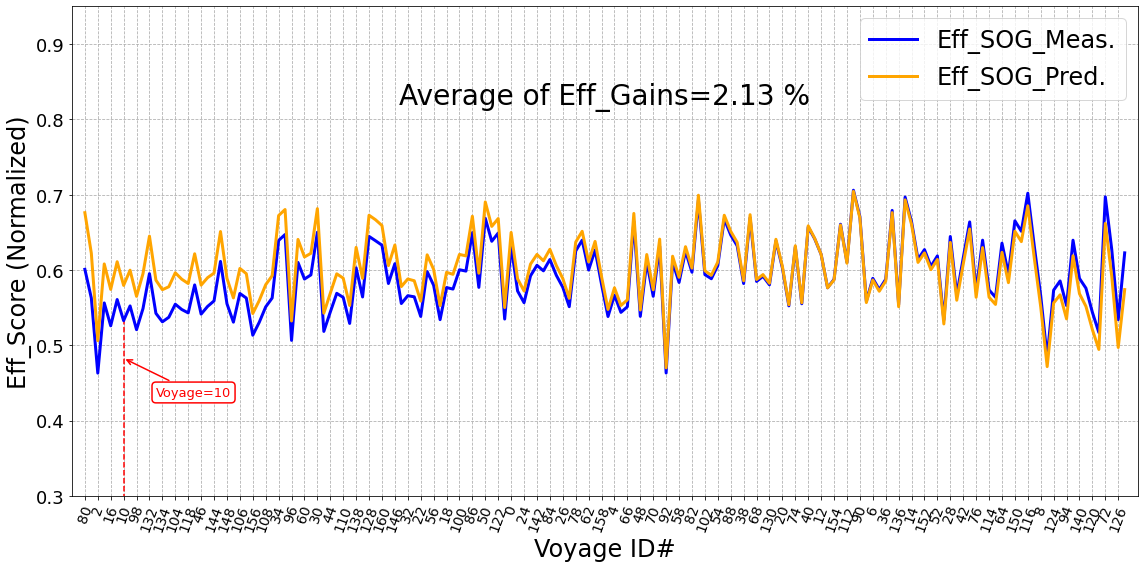

In [99]:
####Plot

# Extract the values from the 'orig_index' column to use as x-ticks
x_ticks = df_sorted_eff_test['orig_index']

plt.figure(figsize=(16,8))

plt.plot(df_sorted_eff_test.eff_meas, label="Eff_SOG_Meas.", color='blue', linewidth=3)
plt.plot(df_sorted_eff_test.eff_pred, label="Eff_SOG_Pred.", color='orange', linewidth=3)

# Set the x-ticks and labels
show_even_ticks = seq_idx % 2 == 0
if show_even_ticks:
#     x_ticks_to_show = [x_ticks[i] if x_ticks[i] % 2 == 0 else '' for i in range(len(x_ticks))]
    x_ticks_to_show = [x for x in x_ticks if x % 2 == 0]
else:
#     x_ticks_to_show = [x_ticks[i] if x_ticks[i] % 2 != 0 else '' for i in range(len(x_ticks))]
    x_ticks_to_show = [x for x in x_ticks if x % 2 != 0]

plt.xticks(range(0, len(x_ticks), 2), x_ticks_to_show, fontsize=14, rotation=70)  # Adjust rotation and fontsize as needed

eff_meas_value = df_sorted_eff_test.loc[df_sorted_eff_test['orig_index'] == seq_idx, ['eff_meas', 'eff_pred']].min(axis=1).values
# Add the vertical line from the x-axis to the point in the plot
indices_of_seq_idx = [i for i, x in enumerate(x_ticks_to_show) if x == seq_idx]
vline_x = indices_of_seq_idx[0] * 2

plt.vlines(x=vline_x, ymin=0, ymax=eff_meas_value, colors='red', linestyles='--')

# Annotate the point with a straight, short arrow and red text inside a bounding box
arrow_props = dict(arrowstyle='->', lw=1.5, color='red')
bbox_props = dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white', lw=1.5)
plt.annotate('Voyage=' + str(seq_idx), xy=(vline_x, eff_meas_value-0.05), xytext=(vline_x+5, eff_meas_value - 0.1),
             fontsize=13, arrowprops=arrow_props, color='red', bbox=bbox_props)


print('\n Metrics for Eff-score predictions using predicted SOG')
mse_eff2, rmse_eff2, R2_eff2, mae_eff2, rmse_n2=metrics_eval(Y_act2, df_eff_test.eff_meas)

  
# plt.title('Sum_Eff_diffs=' + str(np.round(eff_diff_sum, 4)) + ',   Sum_Eff_gains=' + str(np.round(eff_gain_sum, 4))
#           , fontsize=18)

# Define the title text
# title_text = 'Sum of Eff_diffs='+str(np.round(df_eff_test_sum_avg.loc['sum', 'eff_diff'], 2))+'\n \n  Sum of Eff_gains='+str(np.round(df_eff_test_sum_avg.loc['avg', 'eff_gain'], 4))
# title_text = 'Sum of Eff_diffs='+str(np.round(df_eff_test_sum_avg.loc['sum', 'eff_diff'], 2))
title_text = 'Average of Eff_Gains=' + str(np.round(df_eff_test_sum_avg.loc['avg', 'eff_gain'], 2))+' %' 

# Add the title inside the figure using plt.text
plt.text(0.5, 0.80, title_text, horizontalalignment='center', fontsize=28, transform=plt.gca().transAxes)


plt.xlabel("Voyage ID#", fontsize=24)
plt.ylabel('Eff_Score (Normalized)', fontsize=24)
# plt.ylim(0, 1.05)
plt.ylim(0.30, 0.95)

plt.yticks(fontsize=18);
plt.legend(loc="upper right", fontsize=24)
plt.grid(linestyle='--')

x_min = min(x_ticks)-2
x_max = max(x_ticks)+2
plt.xlim(x_min, x_max)

plt.tight_layout()
plt.savefig(Output_folder+'/Fig_'+model_name+'_Sorted_Eff_Seqs_Pred_Meas'+'.png', dpi=300)
plt.show()

In [100]:
# st=stop

In [101]:
# Find the indexes where eff_pred > eff_meas
indexes = df_eff_test[df_eff_test['eff_pred'] > df_eff_test['eff_meas']].index

# Count how many times this condition is met
count = len(indexes)

# Calculate the highest and lowest gain
highest_gain = (df_eff_test['eff_pred'] - df_eff_test['eff_meas']).max()
lowest_gain = (df_eff_test['eff_pred'] - df_eff_test['eff_meas']).min()

# Find the indexes where eff_pred < eff_meas
indexes_pred_less_than_meas = df_eff_test[df_eff_test['eff_pred'] < df_eff_test['eff_meas']].index

# Count how many times eff_pred < eff_meas
count_pred_less_than_meas = len(indexes_pred_less_than_meas)

# Print the results
print("Number of times eff_pred > eff_meas:", count)
print ('')
print("Indexes where eff_pred > eff_meas:", indexes)
print ('')
print("Number of times eff_pred < eff_meas:", count_pred_less_than_meas)
print ('')
print("Indexes where eff_pred < eff_meas:", indexes_pred_less_than_meas)

print("Highest gain:", highest_gain)
print("Lowest gain:", lowest_gain)


Number of times eff_pred > eff_meas: 114

Indexes where eff_pred > eff_meas: Int64Index([  0,   2,   3,   4,   9,  10,  11,  13,  15,  16,
            ...
            146, 147, 148, 149, 151, 153, 156, 157, 158, 160],
           dtype='int64', length=114)

Number of times eff_pred < eff_meas: 48

Indexes where eff_pred < eff_meas: Int64Index([  1,   5,   6,   7,   8,  12,  14,  17,  27,  28,  29,  31,  36,
             40,  41,  42,  47,  51,  52,  53,  61,  63,  64,  71,  72,  73,
             74,  76,  81,  87,  90,  94, 109, 112, 114, 116, 120, 124, 126,
            127, 136, 140, 150, 152, 154, 155, 159, 161],
           dtype='int64')
Highest gain: 0.07518099028585234
Lowest gain: -0.04875145325262542


In [102]:
# Find the indexes where eff_pred > eff_meas
indexes = df_eff_test[df_eff_test['eff_pred'] > df_eff_test['eff_meas']].index

# Count how many times this condition is met
count = len(indexes)

# Calculate the highest and lowest gain
highest_gain = (df_eff_test['eff_pred'] - df_eff_test['eff_meas']).max()
lowest_gain = (df_eff_test['eff_pred'] - df_eff_test['eff_meas']).min()

# Find the indexes where eff_pred < eff_meas
indexes_pred_less_than_meas = df_eff_test[df_eff_test['eff_pred'] < df_eff_test['eff_meas']].index

# Count how many times eff_pred < eff_meas
count_pred_less_than_meas = len(indexes_pred_less_than_meas)

# Print the results
print("Number of times eff_pred > eff_meas:", count)
print ('')
print("Indexes where eff_pred > eff_meas:", indexes)
print ('')
print("Number of times eff_pred < eff_meas:", count_pred_less_than_meas)
print ('')
print("Indexes where eff_pred < eff_meas:", indexes_pred_less_than_meas)

print("Highest gain:", highest_gain)
print("Lowest gain:", lowest_gain)


# Calculate the percentage of eff_pred > eff_meas
percentage_pred_greater_than_meas = round(count / len(df_eff_test),2) * 100

# Calculate the percentage of eff_pred < eff_meas
percentage_pred_less_than_meas = round(count_pred_less_than_meas / len(df_eff_test),2) * 100

# Print the results
print ('')

print("Percentage of eff_pred > eff_meas:", percentage_pred_greater_than_meas, "%")
print("Percentage of eff_pred < eff_meas:", percentage_pred_less_than_meas, "%")

Number of times eff_pred > eff_meas: 114

Indexes where eff_pred > eff_meas: Int64Index([  0,   2,   3,   4,   9,  10,  11,  13,  15,  16,
            ...
            146, 147, 148, 149, 151, 153, 156, 157, 158, 160],
           dtype='int64', length=114)

Number of times eff_pred < eff_meas: 48

Indexes where eff_pred < eff_meas: Int64Index([  1,   5,   6,   7,   8,  12,  14,  17,  27,  28,  29,  31,  36,
             40,  41,  42,  47,  51,  52,  53,  61,  63,  64,  71,  72,  73,
             74,  76,  81,  87,  90,  94, 109, 112, 114, 116, 120, 124, 126,
            127, 136, 140, 150, 152, 154, 155, 159, 161],
           dtype='int64')
Highest gain: 0.07518099028585234
Lowest gain: -0.04875145325262542

Percentage of eff_pred > eff_meas: 70.0 %
Percentage of eff_pred < eff_meas: 30.0 %


In [103]:
df_counts

,Improved_Fuel_Vs,Not_Improved_Fuel_Vs,Improved_Time_Vs,Not_Improved_Time_Vs,Improved_Eff_Vs,Not_Improved_Eff_Vs
Count,141,21,19,143,114,48
Percentage,87.0,13.0,12.0,88.0,70.0,30.0


In [104]:
display(df_st_rt.round(2))

,SOG_Meas,SOG_Pred,improv
fuel,1256.62,1118.43,11.00
time,22.32,23.75,-6.41
distance,349.20,336.28,3.70
sog_avg,1.67,1.57,5.56


In [105]:
print('nth_mid_sth_fg=', nth_mid_sth_fg)
print('gr_ock_fg=', gr_ock_fg)
print('Eff_limit_combs=',Eff_limit_combs)
print('lag_test=', lag_test)
print('inputs=', inputs_str)

nth_mid_sth_fg= Cruising_Speeds
gr_ock_fg= 1
Eff_limit_combs= ['Top10']
lag_test= 1
inputs= Weathers


In [107]:
from IPython.display import HTML

# Specify the path to the saved HTML file for q2
html_path_q = Output_folder+'/Fig_Measured_Voyage_EFFscore_SOG_seq' + str(seq_idx) + '_Weathers.html'
html_path_q2 = Output_folder+'/Fig_'+model_name+'_Voyage_EFFscore_SOG_seq' + str(seq_idx) + '_Weathers.html'

# Display the saved HTML file in the notebook
HTML(filename=html_path_q)
# # Display the saved HTML file in the notebook
HTML(filename=html_path_q2)